# 生存分析を利用したワランティ発生数予測

今週と来週は、生存分析を使用してワランティ発生数を予測する。

今回はSQLのクエリが頻出する。分析を主眼としたクエリについては、例えば["ビッグデータ分析・活用のためのSQLレシピ"](https://www.amazon.co.jp/dp/B06XRWPPC9/ref=cm_sw_em_r_mt_dp_U_HPOwDb913Z6EE)が詳しい。

## 生存時間分析概論

### 特徴

- 生存時間分析(**Survival analysis**)とは、「ある時点から何らかのイベントが発生する時点までの時間」を対象とした統計分析及びそのための手法である。  
- **Time-to-Event分析(Time-to-Event analysis)**とも呼ばれる。  
- その名のとおり、医療分野における死亡までの時間の分析の他、機械の使用開始から最初の故障が発生するまでの時間や、ある顧客が有料会員になってから退会するまでの期間の分析など、「何らかのイベントが発生するまでの時間」や「一定期間における、次のイベント発生の確率」を分析する際に、分野問わず幅広く使用されている。

- 実問題に適用する際の注意点としては、
    - 既存の生存時間分析の枠組みは、**「説明変数(外生変数)の時間変化がない」**あるいは**「ごく簡単な時間変化」**(線形に増加するなど)が前提とされていることが多い。(比較的最近に提案された機械学習系の生存時間分析の一部は、その限りではないが...)
        - 例えば、ある機械の故障までの生存期間を分析する際に、外部温度を説明変数として取り込みたいとする。この場合は、外部温度は上がったり下がったりするが、説明変数としては、"生存期間の平均外部温度","生存期間の最高外部温度"のように、1つの値として入力する必要がある。よって、時系列変化を取り込みにくい。
    - Time-to-Eventの名のとおり、**次のイベントまで**を対象とする分析である。
        - 例えば今回のワランティ数分析では、同一の車が何度かワランティを申請/処理することがあるが、その場合は"販売->1回目の故障", "1回目の故障->2回目の故障",..., とそれぞれの生存期間サンプルに分けてから、分析を行う必要がある。

- 生存時間分析に特有の概念として、**打ち切り**の存在がある。例えば、今回の例であれば、多くの車は一度も故障せずにデータ収集最終日を迎える廃車を迎えると考えられる。また、死亡時点までの分析であれば、多くの患者は実験最終日まで生存していたり、退院してデータが取れなくなったりするだろう。そのような、イベントを迎えずに期間が終了することを**打ち切り**(または右側打ち切り)と呼ぶ。

### 生存時間分析の流れ

生存時間分析は、一般に次のような手順で行われる。

1. データから各サンプルの生存期間を算出する。終わりが打ち切りであったかどうか、分かるようにしておく。
2. 各サンプルの生存期間と打ち切りの有無から、**生存関数**を推定する。
    - 関数の推定方法としては、**カプラン・マイヤー推定**と**アーレン・ネルソン推定**があるが、おおよそ両者は似たような結果になる。
3. 推定された生存関数をモデルによって近似する。近似方法によって、大まかに以下の4種類に分けられる
    - **ノンパラメトリックモデル**(得られた生存関数をそのまま使う)
    - **セミパラメトリックモデル**(Cox比例ハザードモデルなど)
    - **パラメトリックモデル**(ワイブル分布モデル、指数分布モデルなど)
    - **機械学習モデル**(ランダムサバイバルフォレストなど)
4. モデルを用いて予測を行ったり、モデルを用いて説明変数の影響を検定にかけたりする(投薬の効果の有無など)

#### モデルについて補足

- ノンパラメトリックモデルは、説明変数(外生変数)を持たない。カプラン・マイヤーなどで推測された関数をそのまま用いる方法である。
- セミパラメトリック、パラメトリック、機械学習モデルは、説明変数を持つ。ただし、多くの場合、説明変数は生存期間中に時間変化しないことを前提とする。
- セミパラメトリック、パラメトリックモデルは、比例ハザード性を仮定することが多い。これはどういうことかというと、「外生変数Aが〇〇だった場合(カテゴリ変数の場合)or大きくなるにつれて(連続変数の場合)、各時点の死亡確率が一律XX倍に上昇/下落する」というような仮定である。
- セミパラメトリックモデルは、比例ハザード性とノンパラメトリックを組み合わせたモデルである。何らかのベースラインとなる生存関数を仮定して、説明変数によって、一律に死亡確率が上がったり下がったりするようなモデルである。ベースラインの関数系は特に仮定しないので、柔軟な分、サンプル数が少ない場合は推定誤差も増える。
- パラメトリックモデルは、生存関数が完全に時間と説明変数のみをパラメータとする数式として書ける、と仮定するモデルである。例えば指数分布などがよく用いられる。
- 一部の機械学習モデルは、時間変化する外生変数を取り込むことのできるモデルも存在する。ランダムサバイバルフォレストなど、2000年代後半から提案された、比較的新しいものが多い。
- 今回のケースでの説明変数は、モデルの種類、過去の故障の有無(初めてか、再発か)などが考えられる。

### 生存時間分析のExcelでの例

Excel sheet"20190821_survival_analysis.xlsx"を参照

### (Optional)生存時間分析における数式

ある時点$t$までに死亡している確率$F(t)$は、以下のような、分布関数で与えられる。
$$F(t) = P(u < t) = \int_0^t f(u)du$$

ある時点tにまだ生きている確率$S(t)$は、時点tにまだ死亡していない確率なので、
$$S(t) = 1-F(t)$$

この確率$S(t)$を、$t$の関数とみなし、**生存関数**と呼ぶ。

ある時点tまで生きていて、その後、時間$\delta t$後までに死ぬ確率を時間$\delta t$で割った値、$h(t)$を考える。すなわち、
$$h(t) = \lim_{\delta t \to 0} \left\{\frac{P(t \leq T < t + \delta t | T \geq t)}{\delta t} \right\}$$
これは、死亡確率の強度や密度のように考えることができる。  
$h(t)$に期間$u$をかけた値$h(t)u$は、$u$が小さければ、その期間の死亡確率ととらえることができる。

式変形から、
$$h(t) = - \frac{d}{dt}\left(log S(t)\right)$$
となることが示せる(式変形の過程は省略)。

また、
$$H(t) = \int_0^t h(u)du$$
とおくと、
$$S(t) = exp\left(-H(t)\right)$$
となることが示せる(式変形の過程は省略)。

結果、$H(t)$は
$$H(t) = -logS(t)$$
とも書ける。

※今回省略した式変形については[英語版Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis)に掲載がある。生存分析の教科書としては、[医薬統計のための生存時間データ解析](https://www.amazon.co.jp/dp/4320110358/ref=cm_sw_em_r_mt_dp_U_ye.wDb4BDF7AY)や、[生存時間解析入門](https://www.amazon.co.jp/dp/4130623125/ref=cm_sw_em_r_mt_dp_U_Ye.wDbCMDQF9K)がわかりやすい。

## 今回のケース(ワランティ数の予測)への生存分析の適用の方針

0. データを訓練データとバリデーションデータとテストデータに分割する。今回は、一旦、訓練データを2013年12月31日まで、バリデーションデータを2014年1月1日~2014年12月31日、テストデータを2015年1月1日以降とした。
1. 各パーツについて、購入から故障、または交換から故障までの期間の生存期間データを集計する
2. 生存関数をモデリングする。
3. 生存関数モデルによって、稼働中の全車両の当該パーツについて、故障までの予測期間、及び予想故障月(予測時点+故障までの予測期間)を計算する。
4. 得られた故障予測月データから、各月の予測故障件数を集計する。

## データからの生存期間の算出と集計

まず、データから各パーツの生存期間を算出する。今回のケースでは、生存期間は以下のように分類できる。

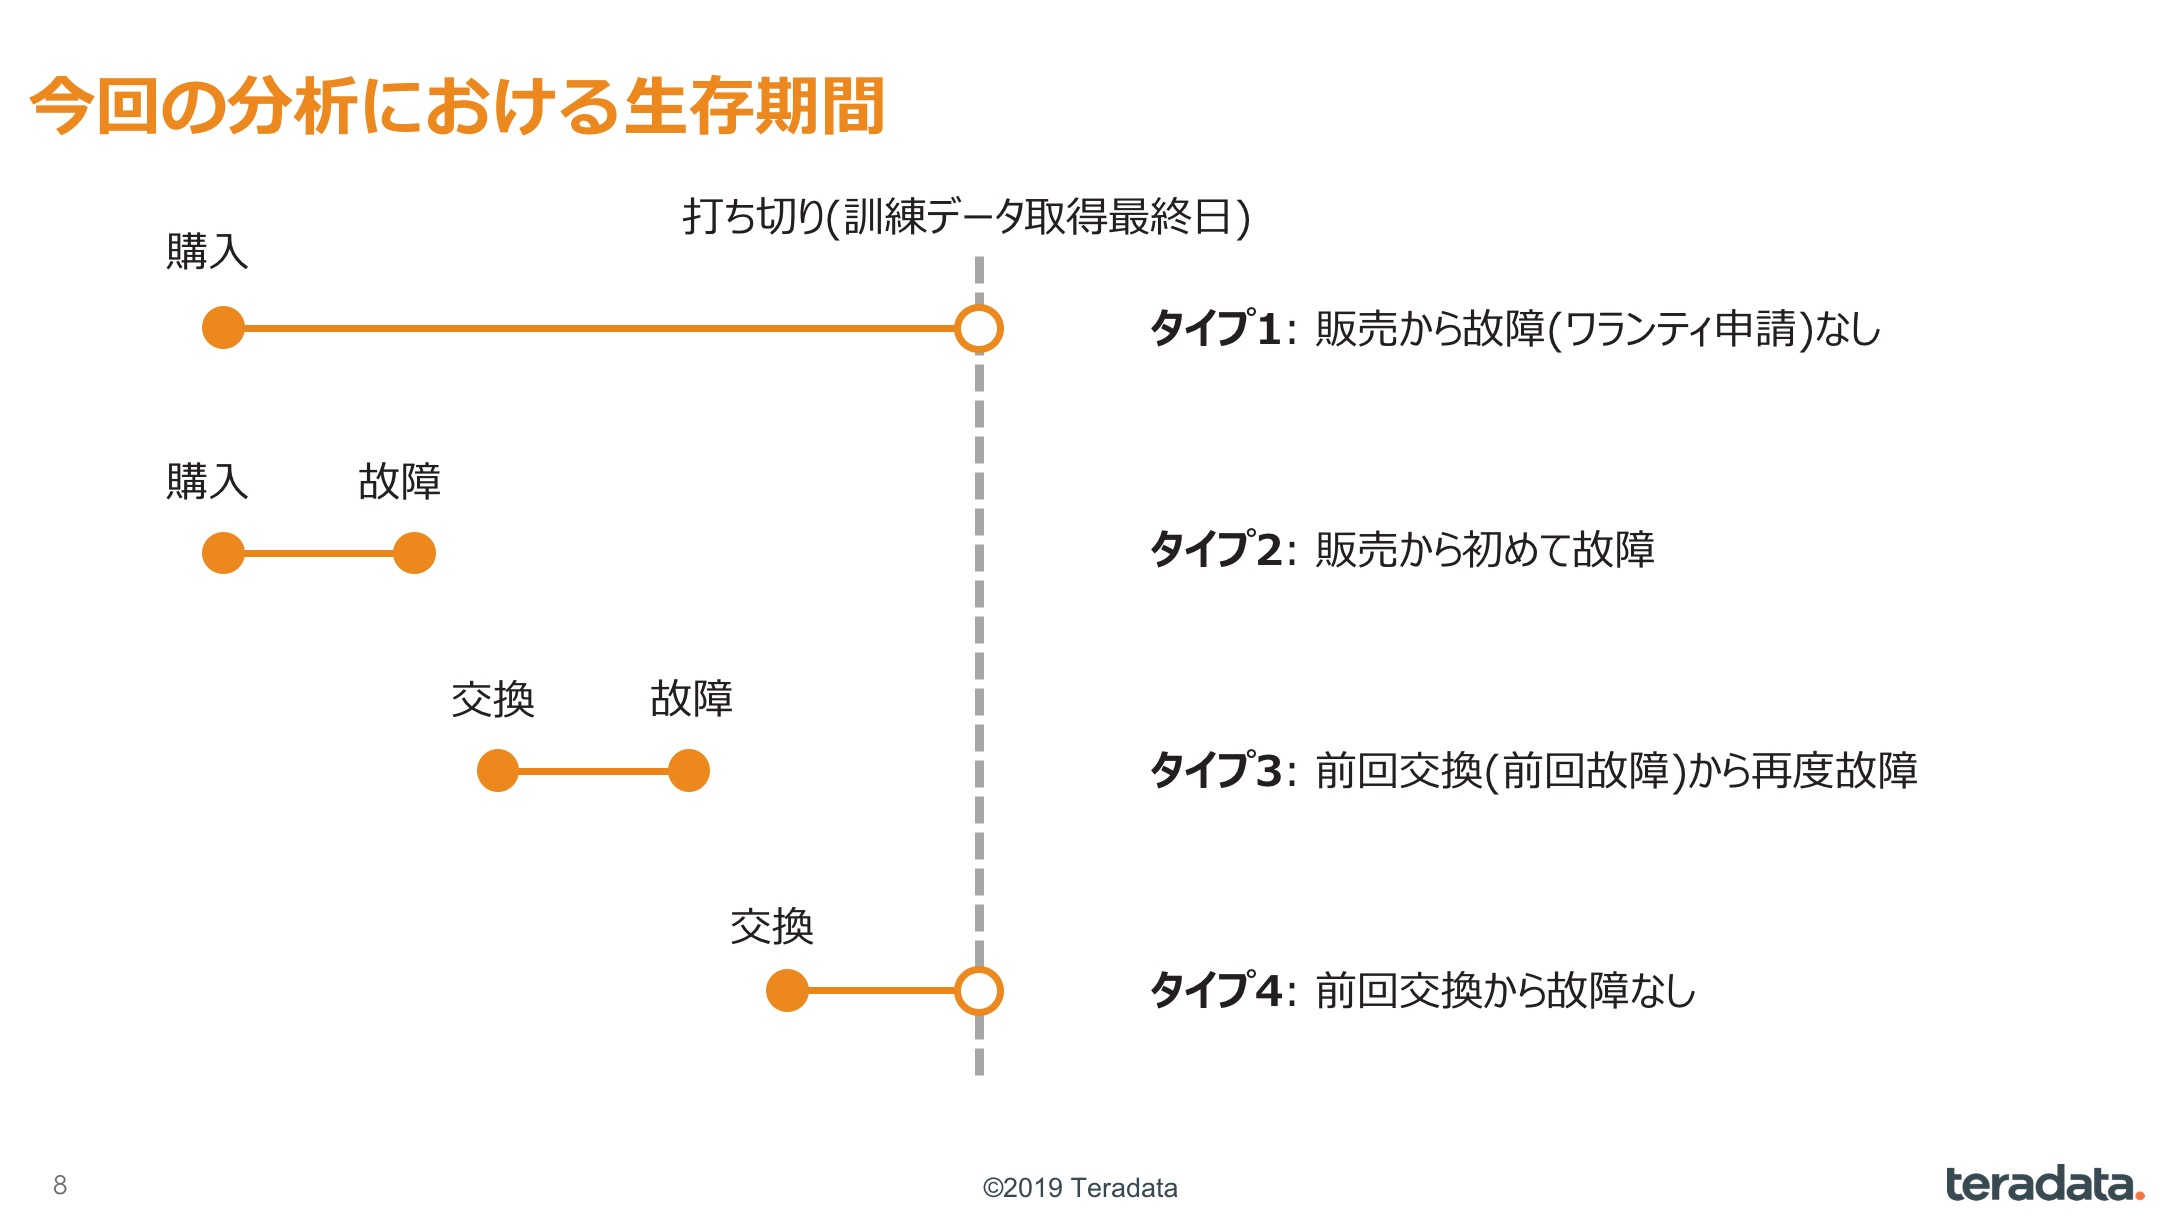

In [1]:
from IPython.display import Image
Image("figures/type_survival_term.jpg")

タイプ1とタイプ2~4で、分けてテーブルを作成、集計する。

### (Optional)PostgreSQLとPython

今回はSQLiteで実行すると遅い & 使用できない関数があったので、PostgreSQLを使用して分析した。  
Suzuki様環境からのTeradataへのアクセス環境が整い次第、Teradataに移行予定であるが、経過措置としてPostgreSQLを利用する。

また、PostgreSQLはMacBookに容易にローカル環境でセットアップすることが可能である。

[こちら](https://qiita.com/mochizukikotaro/items/84204d5c46b67c9b74f4)を参考に、以下の手順で環境をセットアップする。

1. `brew install postgresql`  でHomebrewを使ってインストール  
2. `postgres --version`　でインストールされていることを確認  
3. `postgres -D /usr/local/var/postgres`  でサーバー起動。デフォルト設定では、localhost(127.0.0.1)のポート5432でアクセスができる。  
4. 別ターミナルを開き、`psql -l`  でデータベース一覧を確認。もし新たにデータベースを作成する場合は、`createdb hogehoge`のように作成。  
5. `psql -d hogehoge`でローカルのデータベースhogehogeにログイン。`psql -p 5432 -h localhost -d hogehoge`と明示してもよい。
6. サーバーを起動したターミナルで<kbd>Ctrl + d</kbd>でサーバーを停止できる

インストール後、以下のようにして、接続インスタンスを生成する。sqlalchemyは裏側ではpsycopg2というライブラリを使用しているため、`conda install psycopg2 `でインストールしておく。

In [1]:
from sqlalchemy import create_engine
import pandas as pd

In [3]:
# formatは'postgresql://{ユーザー}:{パスワード}@{ホスト}:{ポート}/{データベース}'
# 眞田環境ではユーザーもパスワードも特に設定せずデフォルトのままなので、それらを省略し、以下のようにして生成
# 裏側でsqlalchemyが勝手にpsycopg2を呼び出してくれる
engine = create_engine('postgresql://:@localhost:5432/suzuki_phase2')

In [4]:
with pd.option_context("display.max_columns", 1000):
    display(pd.read_sql_query("select * from warranty limit 2", engine))

,w_key,w_base_cd,w_prod_base_cd,w_field_claim_div,w_prod_div,w_dmex_div,w_process_month,w_dist_cd,w_dist_country_cd,w_dist_issue_no,w_shop_div,w_shop_cd,w_div1,w_div2,w_div3,w_fixed_div,w_minus_div,w_src_div,w_src_key,w_vin,w_fcok,w_prod_model_cd,w_sales_date,w_failure_date,w_mileage_div,w_mileage,w_causal_part_no,w_trouble_cc,w_trouble_cp,w_trouble_df,w_trouble_mp,w_dtc_1,w_dtc_2,w_operation_cd,w_parts_amt,w_labor_hour,w_labor_amt,w_sublet_hour,w_sublet_amt,w_shipping_amt,w_total_amt,w_cfc_company_cd,w_cfc_rate,w_cfc_amt,w_fc_to_failure,w_sales_to_failure,w_sb_no,w_crt_time_stamp
0,WRAEID200608B000001,118700,118700,1,B,1,200608,5725,AE,0607003,None,None,None,0,0,1,1,2,2006085725B00607003,MHYDN71V45J101139,20050702,YL0A1N7E,20060328,20060617,K,5092,84703-61J00-6GS,None,76,48,None,None,None,QJ04R0,987.0,0.2,470.0,0.0,0.0,296.0,1753.0,None,0,0.0,12,3,None,2017-06-20 14:01:16.950054
1,WRAEID200608B000002,118700,118700,1,B,1,200608,5725,AE,0607006,None,None,None,0,0,1,1,2,2006085725B00607006,MHYDN71V45J101139,20050702,YL0A1N7E,20060328,20060621,K,7783,48830-61J00,None,41,48,None,None,None,LC9999,0.0,0.7,1646.0,1.5,3528.0,0.0,5174.0,None,0,0.0,12,3,None,2017-06-20 14:01:16.952369


#### データロード

- Teams > General > data > warranty_fcok.7z(1.4GB)を解凍すると、warranty.csv(6GB), fcok.csv(7GB)ができる。
- Teams > General > data > load_fcok_warranty_postgresql.sqlを開き、warranty.csv, fcok.csvのパスを、先程解凍した両ファイルのパスに書き換えたのち、このクエリを走らせれば、ロードが完了する。
    - `psql -f thefile.sql -d hogehoge`でログイン&スクリプトを走らせることができる。8分程度で終了する。

### データクレンジング

変な日付が混ざっているので、それらを含むレコードを除去する。

#### W_FAILURE_DATE列

In [2]:
df_w_failure_date_distinct = pd.read_sql_query("""
    select distinct(w_failure_date) from warranty order by w_failure_date""",
                                              engine)

In [ ]:
engine.execute()

In [3]:
df_w_failure_date_distinct["is_error"] = (pd.to_datetime(
    df_w_failure_date_distinct.w_failure_date, errors="coerce").isna())

In [4]:
w_failure_date_error_list = (df_w_failure_date_distinct
                             .loc[df_w_failure_date_distinct.is_error, "w_failure_date"]
                             .to_list())
w_failure_date_error_list[:5]

['00000000', '000001', '000003', '000008', '000009']

In [5]:
error_list_str = ",".join(["'{}'".format(c) for c in w_failure_date_error_list])

In [6]:
df_w_failure_date_error = pd.read_sql_query("""select w_failure_date, count(*) from warranty
where w_failure_date in
({error_list_str})
group by w_failure_date;""".format(error_list_str = error_list_str), engine)

In [11]:
print("""select w_failure_date, count(*) from warranty
where w_failure_date in
({error_list_str})
group by w_failure_date;""".format(error_list_str = error_list_str))

select w_failure_date, count(*) from warranty
where w_failure_date in
('00000000','000001','000003','000008','000009','000010','000011','000012','000013','000014','000015','000016','000017','000018','000019','000020','000021','000022','000024','000026','000027','000028','000030','000032','000050','000052','00230705','01080114','05050720','06122700','10070925','11101108','11101111','12120319','13031900','13040300','19970229','19970230','19970631','20130931')
group by w_failure_date;


In [12]:
df_w_failure_date_error["count"].sum()

16386

16386レコードを除去する。

#### W_SALES_DATE

In [7]:
df_w_sales_date_distinct = pd.read_sql_query("""
    select distinct(w_sales_date) from warranty order by w_sales_date""",
                                               engine)
df_w_sales_date_distinct["is_error"] = (pd.to_datetime(
    df_w_sales_date_distinct.w_sales_date, errors="coerce").isna())
w_sales_date_error_list = (df_w_sales_date_distinct
                             .loc[df_w_sales_date_distinct.is_error, "w_sales_date"]
                             .to_list())
w_sales_date_error_list[:5]

['0', '00000000', '00000020', '02021116', '06090520']

In [8]:
error_list_str_sales = ",".join(["'{}'".format(c) for c in w_sales_date_error_list])
df_w_sales_date_error = pd.read_sql_query("""select w_sales_date, count(*) from warranty
where w_sales_date in
({error_list_str_sales})
group by w_sales_date;""".format(error_list_str_sales = error_list_str_sales), 
                                          engine)
df_w_sales_date_error.head()

,w_sales_date,count
0,0,133
1,00000000,94034
2,00000020,2
3,02021116,1
4,06090520,1


In [15]:
df_w_sales_date_error["count"].sum()

94330

94330レコードを除去する

#### V_FCOK

In [9]:
df_v_fcok_distinct = pd.read_sql_query("""
    select distinct(v_fcok) from fcok order by v_fcok""",engine)
df_v_fcok_distinct["is_error"] = (pd.to_datetime(
    df_v_fcok_distinct.v_fcok, errors="coerce").isna())
v_fcok_error_list = (df_v_fcok_distinct
                             .loc[df_v_fcok_distinct.is_error, "v_fcok"]
                             .to_list())
v_fcok_error_list[:5]

['20000100']

In [10]:
error_list_str_fcok = ",".join(["'{}'".format(c) for c in v_fcok_error_list])
df_v_fcok_error = pd.read_sql_query("""select v_fcok, count(*) from fcok
where v_fcok in
({error_list_str_fcok})
group by v_fcok;""".format(error_list_str_fcok = error_list_str_fcok), engine)
df_v_fcok_error.head()

,v_fcok,count
0,20000100,10


10レコードを除去する

### タイプ1の生存期間データの作成と集計

- 購入から、ワランティが一度も申請されずに訓練データ収集最終日(2013年12月31日)を迎えたパーツについて、生存期間を作成・集計する。
- どのパーツがどの車種に含まれているかは、**全期間の**ワランティデータを車種コード上3桁、パーツコード上5-3桁を用いて集計し、件数が5件以上あった組み合わせについて、そのパーツ(群)はその車種(群)の車に含まれていると判断する。
- 訓練データ期間中のワランティデータに、同一VINで、上5-3桁が同じパーツのワランティレコードが含まれていた場合は、そのVINのそのパーツ(群)は、ワランティ申請歴あり、ということで、集計から除外する。
- 生産記録テーブル(fcokテーブル)については購入日を示す項目が含まれていないため、V_FCOK列(FCOK日)をもって、購入日とみなす。実際にはFCOK日から購入日までは1~3ヶ月程度のラグがあることに留意。
- 後述のタイプ2~4にあわせ、生存期間の精度(粒度)は月単位とする。

- 各種フィルタリング条件は以下のとおり。
    - 生産テーブル
        - 国内拠点生産(V_BASE_CD = '100100')
        - 四輪(V_PROD_DIV = 'B')
        - <font color=red>V_SPEC = "000"</font>
    - ワランティテーブル
        - 国内向け出荷分(W_DMEX_DIV = '0')
        - 国内拠点生産(W_PROD_BASE_CD = '100100')
        - 国内拠点処理(W_BASE_CD = '100100')
        - 四輪(W_PROD_DIV = 'B')
        - <font color=red>W_FIELD_CLAIM_DIV = '1'</font>

#### パーツ-モデルの多対多関係を示す中間テーブルの作成

In [11]:
cutoff_n_master = 5 # そのパーツ-モデルの組み合わせのワランティデータが5件以上ある場合は、マスターに登録

In [13]:
sql_master = """
select 
    substr(w_causal_part_no, 1, 9) as causal_part
    ,substr(w_prod_model_cd, 1, 3) as model_code
    ,count(*) as n
from warranty
where 
    W_SALES_DATE not in ({error_list_str_sales})
    and W_FAILURE_DATE not in ({error_list_str})
    and W_PROD_BASE_CD = '100100'
    and W_BASE_CD = '100100'
    and W_PROD_DIV = 'B'
    and W_DMEX_DIV = '0'
    and w_prod_model_cd is not null
group by causal_part, model_code
having count(*) >= {cutoff_n_master};
""".format(error_list_str_sales=error_list_str_sales, 
           error_list_str=error_list_str,
           cutoff_n_master=cutoff_n_master)

In [17]:
%%time
df_part_model_master = pd.read_sql_query(sql_master, engine)

CPU times: user 268 ms, sys: 29.7 ms, total: 297 ms
Wall time: 15.8 s


In [21]:
df_part_model_master.head(5)

,causal_part,model_code,n
0,*1150-JB2,YR6,16
1,*1150-MC1,YJ0,8
2,*1150-MC2,YJ0,14
3,*2271-CT5,YC0,10
4,*2271-CV5,YC0,6


In [14]:
# テーブルに保存しておく
engine.execute("create table IF NOT EXISTS part_model_master as " + sql_master)

#### 集計を実行

In [15]:
# 今回対象とするパーツ群
selected_part_TD = ["27610-76G", "37950-58J", "95411-82K", 
                    "09283-350", "33920-77F", "33220-76G", "55311-75F",
                    "55311-72J", "53200-58J", "84702-70K"]
target_parts_str = ",".join(["'{}'".format(part) for part in selected_part_TD])

cutoff_date = '2014-01-01' # 訓練データ最終日 + 1

In [16]:
sql_term_type1 = """
-- 生産テーブルから必要なデータを抽出し、FCOKを月単位にならす
with t_fcok as (
    select 
        to_date(substr(v_fcok, 1, 6), 'YYYYMM') as fcok_month
        ,substr(v_prod_model_cd, 1, 3) as model_code
        ,v_vin
    from fcok
    where v_base_cd = '100100'
        and v_prod_div = 'B'
        and v_spec = '000'
        and v_fcok not in ('20000100')
        and v_fcok < '{cutoff_date}'
)

-- ワランティテーブルから必要なデータを抽出し、パーツ番号を上5-3桁に切り取り、(VIN-パーツ番号)がユニークになるように
, t_warranty as (
    select 
        substr(w_causal_part_no, 1, 9) as causal_part
        ,w_vin
    from warranty
    where 
        W_SALES_DATE not in ({error_list_str_sales})
        and W_FAILURE_DATE not in ({error_list_str})
        and W_PROD_BASE_CD = '100100'
        and W_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
        and W_FIELD_CLAIM_DIV = '1'
        and to_date(w_process_month,'YYYYMM') < '{cutoff_date}'
    group by w_vin, causal_part
)

-- 抽出した生産テーブルとパーツ-モデルマスタデータから、対象パーツについて、生産された全パーツのテーブルを作成。生存期間も計算。
, term_all as (
    select
        t_fcok.model_code
        ,causal_part
        ,extract(year from age('{cutoff_date}', fcok_month))*12
                + extract(month from age('{cutoff_date}', fcok_month)) as month_passed
        ,v_vin || causal_part as vin_part
    from t_fcok
    join part_model_master as pm_master
        on pm_master.model_code = t_fcok.model_code
    where pm_master.causal_part in ({target_parts_str})
)

-- ワランティデータに出現したVIN-パーツのペアは除外したのち、パーツxモデルx生存期間毎にパーツ数を集計する
select
    model_code
    ,causal_part
    ,month_passed
    ,count(*) as sample_count
from term_all
where term_all.vin_part not in (
    select w_vin || causal_part from t_warranty
    where causal_part in ({target_parts_str})
    )
group by model_code, causal_part, month_passed
;""".format(cutoff_date=cutoff_date, error_list_str=error_list_str,
            error_list_str_sales=error_list_str_sales,
            target_parts_str=target_parts_str)

In [17]:
%%time
df_term_type1 = pd.read_sql_query(sql_term_type1, engine)

CPU times: user 23.1 ms, sys: 13.8 ms, total: 37 ms
Wall time: 1min 54s


In [26]:
df_term_type1.shape

(9024, 4)

In [27]:
df_term_type1.head()

,causal_part,model_code,month_passed,sample_count
0,27610-76G,YR6,38.0,994
1,53200-58J,YR0,149.0,4124
2,55311-72J,Y1J,20.0,6989
3,53200-58J,YJ0,138.0,13958
4,95411-82K,YB7,7.0,4499


### タイプ2~4の生存期間データの作成と集計

- 以下のパターンのパーツについて、生存期間を作成・集計する。
    - 2.購入から初回故障
    - 3.前回交換から今回故障
    - 4.前回交換から故障せずに訓練データ集計最終日(2013年12月31日)を迎える
- 交換は、ワランティテーブルのW_PROCESS_MONTHの月に交換作業があったとみなす。したがって、生存期間の精度(粒度)は月単位となる。
- 交換および故障は、主原因品番(W_CAUSAL_PART_NO)のパーツのみが故障し、交換されたとみなす。実際には、その他のパーツも故障・交換されている可能性が高いことに留意。
- 同じパーツが過去に交換されたか否かは、VINとパーツコード(全桁)と交換日(W_PROCESS_MONTH)と故障日(W_FAILURE_DATE)を使用して判断した。

In [18]:
sql_term_type2_4 = """
-- ワランティテーブルから必要なデータを抽出し、パーツ番号を上5-3桁に切り取り、(VIN-パーツ番号-故障日)がユニークになるように 
with t_warranty as (
    select 
        w_vin
        ,w_failure_date
        ,to_date(max(w_process_month), 'YYYYMM') as process_month
        ,to_date(substr(w_failure_date, 1, 6), 'YYYYMM') as failure_month
        ,to_date(substr(max(w_sales_date), 1, 6), 'YYYYMM') as sales_month
        ,substr(w_causal_part_no, 1, 9) as causal_part
        ,substr(max(w_prod_model_cd), 1, 3) as model_code
    from warranty
    where        
        W_SALES_DATE not in ({error_list_str_sales})
        and W_FAILURE_DATE not in ({error_list_str})
        and W_PROD_BASE_CD = '100100'
        and W_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
        and W_FIELD_CLAIM_DIV = '1'
        and to_date(w_process_month,'YYYYMM') <= '{cutoff_date}'
        and substr(w_causal_part_no, 1, 9) in ({target_parts_str})
    group by w_vin, causal_part, w_failure_date
)
-- 同一VIN,パーツ番号内で、故障日を用いて並び替え、次回故障日(next_failure_month)と、前回交換日(prev_process_month)の列を追加
, t_shifted as (
    select 
        process_month
        ,w_vin
        ,causal_part
        ,model_code
        ,w_failure_date
        ,failure_month
        ,sales_month
        ,lag(process_month) over(partition by w_vin, causal_part order by w_failure_date) as prev_process_month
        ,lead(failure_month) over(partition by w_vin, causal_part order by w_failure_date) as next_failure_month
    from t_warranty
)
-- 期間を計算。交換->打ち切り、交換->次回故障をterm_nextで、販売->故障をterm_prevとして算出している。
-- 打ち切りのterm_nextには、打ち切りフラグを付加。term_prevで前回交換->今回故障も含めてしまうと二重に計上してしまうことに注意。
, terms as (
    select 
        causal_part
        ,model_code
        ,case when next_failure_month is null then 
            extract(year from age('{cutoff_date}', process_month)) * 12 
                + extract(month from age('{cutoff_date}', process_month))
            else
                extract(year from age(next_failure_month, process_month)) * 12 
                    + extract(month from age(next_failure_month, process_month))
            end as term_next
        ,case when next_failure_month is null then 1 else 0 end as cutoff_flag
        ,case when prev_process_month is null then
            extract(year from age(failure_month, sales_month)) * 12 
                + extract(month from age(failure_month, sales_month))
            else null
            end as term_prev
    from t_shifted
)
-- term_nextとterm_prevをそれぞれパーツxモデルx期間x打ち切りフラグごとに集計してから、テーブルをunionしている。
select 
    causal_part
    ,model_code
    ,term_next as month_passed
    ,count(*) as sample_count
    ,cutoff_flag
from terms
group by causal_part, model_code, month_passed, cutoff_flag
union
select
    causal_part
    ,model_code
    ,term_prev as month_passed
    ,count(*) as sample_count
    ,0 as cutoff_flag
from terms
where term_prev is not null
group by causal_part, model_code, month_passed, cutoff_flag
;""".format(error_list_str=error_list_str, error_list_str_sales=error_list_str_sales,
           target_parts_str=target_parts_str, cutoff_date=cutoff_date)

In [19]:
%%time
df_term_type2_4 = pd.read_sql_query(sql_term_type2_4, engine)

CPU times: user 34 ms, sys: 7.48 ms, total: 41.5 ms
Wall time: 16.2 s


In [30]:
df_term_type2_4.shape

(18800, 5)

In [31]:
df_term_type2_4.head()

,causal_part,cutoff_flag,model_code,month_passed,sample_count
0,09283-350,1,YC2,149.0,4
1,55311-72J,1,YK1,1.0,1
2,27610-76G,1,YB2,104.0,3
3,55311-75F,1,YB2,77.0,17
4,27610-76G,0,YR0,61.0,14


### 生存期間データの統合

テーブルを足し合わせる。

In [32]:
df_term_type1.assign(cutoff_flag=1).head()

,causal_part,model_code,month_passed,sample_count,cutoff_flag
0,27610-76G,YR6,38.0,994,1
1,53200-58J,YR0,149.0,4124,1
2,55311-72J,Y1J,20.0,6989,1
3,53200-58J,YJ0,138.0,13958,1
4,95411-82K,YB7,7.0,4499,1


In [33]:
df_term_type2_4.head()

,causal_part,cutoff_flag,model_code,month_passed,sample_count
0,09283-350,1,YC2,149.0,4
1,55311-72J,1,YK1,1.0,1
2,27610-76G,1,YB2,104.0,3
3,55311-75F,1,YB2,77.0,17
4,27610-76G,0,YR0,61.0,14


In [20]:
df_all = (df_term_type1
          .assign(cutoff_flag=1)
          .merge(df_term_type2_4, 
                 on=["causal_part", "model_code", "month_passed", "cutoff_flag"],
                 how="outer"))
df_all["sample_count"] = df_all["sample_count_x"].fillna(0) + df_all["sample_count_y"].fillna(0)
df_all = df_all.groupby(["causal_part", "month_passed", "cutoff_flag"])["sample_count"].sum().reset_index()
df_all.head()

,causal_part,month_passed,cutoff_flag,sample_count
0,09283-350,-2.0,0,13.0
1,09283-350,-1.0,0,140.0
2,09283-350,0.0,0,288.0
3,09283-350,0.0,1,8.0
4,09283-350,1.0,0,264.0


In [21]:
df_all_cutoff = (df_all[df_all.cutoff_flag==1]
                 .drop("cutoff_flag", axis=1)
                 .sort_values(by=["causal_part","month_passed"]))

In [22]:
df_all_events = (df_all[df_all.cutoff_flag==0]
                 .drop("cutoff_flag", axis=1)
                 .sort_values(by=["causal_part","month_passed"]))

In [37]:
df_all_cutoff[df_all_cutoff.month_passed<0]

,causal_part,month_passed,sample_count


In [26]:
df_all_events[df_all_events.month_passed<0]

,causal_part,month_passed,sample_count
0,09283-350,-2.0,13.0
1,09283-350,-1.0,140.0
365,27610-76G,-4.0,1.0
366,27610-76G,-3.0,5.0
367,27610-76G,-2.0,27.0
368,27610-76G,-1.0,67.0
735,33220-76G,-4.0,1.0
736,33220-76G,-3.0,5.0
737,33220-76G,-2.0,15.0
738,33220-76G,-1.0,81.0


マイナスの値が出てしまっている。
- 処理日の入力が遅れてしまい、かつ交換後すぐに故障しまい、前回処理日 > 今回故障日となった
- 販売日よりも先に故障日が入力されているケース

などが原因として考えられる。  
一旦、ここでは<font color=red>これらのレコードは除外することで対応する。</font>

In [23]:
df_all_events = df_all_events.loc[df_all_events.month_passed>=0]
df_all_events = (df_all_events
                 .groupby(["causal_part", "month_passed"])
                 ["sample_count"].sum().reset_index())

In [28]:
df_all_events[df_all_events.month_passed<0]

,causal_part,month_passed,sample_count


## カプラン・マイヤー推定による生存関数の推定

In [24]:
survival_table = (df_all_events
                 .merge(df_all_cutoff, on=["causal_part", "month_passed"], how="left")
                 .fillna(0)
                 .rename(columns={"sample_count_x":"n_event", "sample_count_y":"cutoff"}))
survival_table.head()

,causal_part,month_passed,n_event,cutoff
0,09283-350,0.0,288.0,8.0
1,09283-350,1.0,264.0,58406.0
2,09283-350,2.0,220.0,62908.0
3,09283-350,3.0,231.0,59147.0
4,09283-350,4.0,202.0,56647.0


In [25]:
df_n_total = survival_table.groupby("causal_part")["n_event", "cutoff"].sum()
df_n_total = df_n_total.sum(axis=1).to_frame(name="total").reset_index()

In [26]:
survival_table = survival_table.merge(df_n_total, on="causal_part")

In [27]:
survival_table["sample_decrease"] = survival_table.groupby("causal_part")["n_event", "cutoff"].shift().sum(axis=1)

In [28]:
survival_table["n_at_risk"] = (survival_table["total"]
                               - survival_table.groupby("causal_part")["sample_decrease"]
                                 .transform(lambda x: x.cumsum()))

In [29]:
survival_table["survive_ratio"] = (1 - survival_table["n_event"]/survival_table["n_at_risk"])

In [30]:
survival_table["survival_function"] = (survival_table.groupby("causal_part")
                                       ["survive_ratio"]
                                       .transform(lambda x: x.cumprod()))

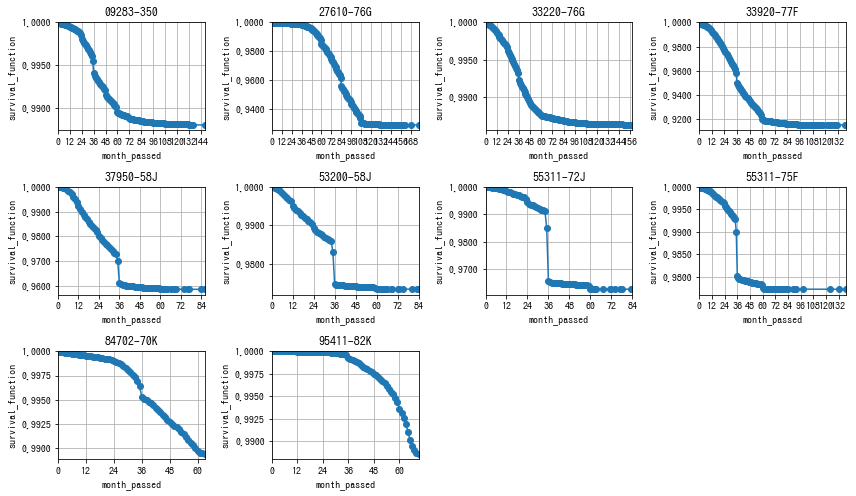

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(12,7))
for i,part in enumerate(survival_table.causal_part.unique()):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = survival_table[survival_table.causal_part==part].set_index("month_passed")
    df_tmp["survival_function"].plot(ax=ax, style="o-")
    ax.set(ylabel="survival_function", xlabel="month_passed",
          title=part, ylim=[None,1])
    max_x = df_tmp.index.max()
    ax.set_xticks(np.arange(0, max_x+1, 12))
    ax.grid()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.04f'))

plt.tight_layout()

- 極端な減少があるもの("53311-75F"など)は、ワイブル分布などのパラメトリックな方法ではモデリングが難しいと思われる。ノンパラメトリックまたはセミパラメトリックモデルによるモデリングを試みる。
- 急激な減少のないものについては、パラメトリックな方法も使用できるだろう。

**ディスカッション**
- **60ヶ月以降は含めないで良い。**
    - **品番により異なるが、重要部品は60ヶ月、ほかは36ヶ月までしか原則として、ワランティは受け付けない**
- **W_FIELD_CLAIM_DIV**は1に限定する必要あり。

In [49]:
survival_table.head()

,causal_part,month_passed,n_event,cutoff,total,sample_decrease,n_at_risk,survive_ratio,survival_function
0,09283-350,0.0,288.0,8.0,7117395.0,0.0,7117395.0,0.999960,0.999960
1,09283-350,1.0,264.0,58406.0,7117395.0,296.0,7117099.0,0.999963,0.999922
2,09283-350,2.0,220.0,62908.0,7117395.0,58670.0,7058429.0,0.999969,0.999891
3,09283-350,3.0,231.0,59147.0,7117395.0,63128.0,6995301.0,0.999967,0.999858
4,09283-350,4.0,202.0,56647.0,7117395.0,59378.0,6935923.0,0.999971,0.999829


In [32]:
# 期間の長さ
survival_table["term_length"] = (survival_table
                                 .groupby("causal_part")["month_passed"]
                                 .shift(-1) 
                                 - survival_table["month_passed"])

In [33]:
# ハザード関数
survival_table["hazard_rate"] = (survival_table["n_event"] /
                                 survival_table["n_at_risk"] /
                                 survival_table["term_length"])

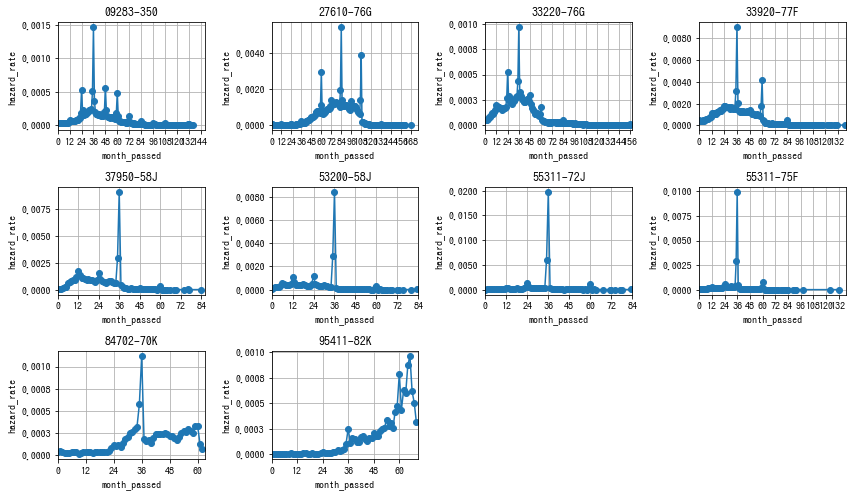

In [34]:
fig = plt.figure(figsize=(12,7))
for i,part in enumerate(survival_table.causal_part.unique()):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = survival_table[survival_table.causal_part==part].set_index("month_passed")
    df_tmp["hazard_rate"].plot(ax=ax, style="o-")
    ax.set(ylabel="hazard_rate", xlabel="month_passed",
          title=part)
    max_x = df_tmp.index.max()
    ax.set_xticks(np.arange(0, max_x+1, 12))
    ax.grid()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.04f'))

plt.tight_layout()

- 36ヶ月、60ヶ月など、ワランティ期間切れの時期の駆け込み需要か、ハザードレートが極端に高くなっている。
- 徐々にハザードレートが上昇するものは、摩耗性の故障が多いと推測される。
- 初期不良が多いもの(ハザードレートが0近辺で高く、徐々に減少していくもの)は、今回の対象パーツ群にはあまり見られなかった。

**ディスカッション**
- ピークを除去した後にワイブル分布でフィッティングする方法
- 期間を分けた後にワイブル分布でフィッティングする方法
- 「車検効果」「ワランティ期限切れ効果」「通常のワイブル分布」の3要素に分けてフィッティングする方法

In [35]:
# 累積ハザード
survival_table["cum_hazard"] = (survival_table
                                .groupby("causal_part")["hazard_rate"]
                                .transform(lambda x: x.cumsum()))

## 生存関数のモデリングと予測

- モデリングに際しては、「外生変数(説明変数)を含めるか否か」で2種類に分かれる。
    - 外生変数を含めない場合、ノンパラメトリックまたはパラメトリックが使用できる。
    - 外生変数を含める場合は、セミパラメトリックまたはパラメトリックまたは機械学習系が使用できる。
- 生存分析において外生変数を入れることは、生存関数に階層構造を仮定することとイメージできる。例えば、病気の男性の生存関数があるとして、それに血液型を説明変数として加えるとする。この場合、お互いに似たような形状の生存関数だが、血液型ごとに若干異なる生存関数がフィットされる。
    - もし血液型毎に別々に生存関数をフィットした場合は、各々の生存関数は互いに全く違う形状を取ることもできるが、血液型を説明変数に組み込んだ場合は、互いに全く違う形状は取ることはできない。

- 今回のケースで外生変数を含めるとすれば、以下のようなアプローチがあるだろう
    - パーツ毎にモデリングし、「1度目の故障か否か」を説明変数として加える。
    - パーツ毎にモデリングし、「パーツが搭載されているモデルの系統」を説明変数として加える。
    - パーツグループをまとめてモデリングし、「パーツの個別の種類」を説明変数として加える。
    - パーツグループをまとめてモデリングし、「パーツの個別の種類」、「1度目の故障か否か」、「パーツが搭載されているモデルの系統」を説明変数として加える。

今回の方針としては、まずは外生変数なしでノンパラメトリック、パラメトリックを試す。

Pythonによる生存分析モデリングで良く用いられるライブラリは、次の2つだろう。
- lifelines(クラシカルな生存分析のモデル一般を揃えており、検定のモジュールも含まれている。)
- scikit-survival(比較的最近の機械学習系のモデルが多く実装されている。)

それぞれ、以下でインストールできる
- `conda install -c conda-forge lifelines`
- `conda install -c temporary-recipes scikit-survival`
    - もし上手くinstallされない場合は、`conda install scikit-lean=0.20.0`でscikit-learnのversionを0.20にupgradeしてから、再度試す。

しかしながら、両方ともインプットデータとして集約前のデータ(エクセルの左上にあったデータのイメージ)にしか対応しておらず、SQL等で大容量のデータを集約したあとのデータについては対応していない。  
小さいデータをさっと生存分析に掛けるには勝手が良いが、今回のケースのような大容量のデータには適用が難しい。  
幸い、ワイブル分布モデルや指数分布モデルのフィッティングは難しくないので、ライブラリを使わずにモデリングを行う。

### ノンパラメトリックモデル

上記で得られた生存関数をそのまま使用するだけである。

In [55]:
survival_table[["causal_part", "month_passed", "survival_function"]].head(5)

,causal_part,month_passed,survival_function
0,09283-350,0.0,0.999960
1,09283-350,1.0,0.999922
2,09283-350,2.0,0.999891
3,09283-350,3.0,0.999858
4,09283-350,4.0,0.999829


In [36]:
# 各経過月数の各パーツに対して、1ヶ月後 ~ 12ヶ月後の故障確率を計算
surv_pred_table = survival_table[["causal_part", "month_passed", "survival_function"]].copy()
for i in range(1,13): # 1,2,..,12
    surv_pred_table[f"fail_rate_{i}"] = 1- (surv_pred_table
                                            .groupby("causal_part")["survival_function"]
                                            .shift(-i) /
                                            surv_pred_table["survival_function"]
                                            )

In [226]:
surv_pred_table.head()

,causal_part,month_passed,survival_function,fail_rate_1,fail_rate_2,fail_rate_3,fail_rate_4,fail_rate_5,fail_rate_6,fail_rate_7,fail_rate_8,fail_rate_9,fail_rate_10,fail_rate_11,fail_rate_12
0,09283-350,0.0,0.999960,0.000037,0.000068,0.000101,0.000130,0.000160,0.000198,0.000230,0.000261,0.000296,0.000335,0.000386,0.000460
1,09283-350,1.0,0.999922,0.000031,0.000064,0.000093,0.000123,0.000160,0.000193,0.000224,0.000259,0.000298,0.000349,0.000423,0.000487
2,09283-350,2.0,0.999891,0.000033,0.000062,0.000092,0.000129,0.000162,0.000193,0.000228,0.000267,0.000318,0.000392,0.000456,0.000514
3,09283-350,3.0,0.999858,0.000029,0.000059,0.000096,0.000129,0.000160,0.000195,0.000234,0.000285,0.000359,0.000423,0.000481,0.000541
4,09283-350,4.0,0.999829,0.000030,0.000067,0.000100,0.000130,0.000166,0.000205,0.000256,0.000330,0.000394,0.000452,0.000511,0.000574


In [37]:
# 60を超えたパーツについては、fail_rate=0とする。(パーツによっては36でも良いかもしれないが、一旦60で。)
surv_pred_table.loc[surv_pred_table.month_passed >= 60, 
                    [c for c in surv_pred_table.columns if "fail" in c]] = 0

In [38]:
surv_pred_table.loc[surv_pred_table.month_passed >= 60].head()

,causal_part,month_passed,survival_function,fail_rate_1,fail_rate_2,fail_rate_3,fail_rate_4,fail_rate_5,fail_rate_6,fail_rate_7,fail_rate_8,fail_rate_9,fail_rate_10,fail_rate_11,fail_rate_12
60,09283-350,60.0,0.989626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,09283-350,61.0,0.989492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,09283-350,62.0,0.989422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,09283-350,63.0,0.989365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,09283-350,64.0,0.989312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
surv_pred_table.shape

(1021, 15)

In [39]:
# databaseのテーブルに書き込み
(surv_pred_table
 .drop("survival_function", axis=1)
 .reset_index(drop=True)
 .to_sql("survival_np_ut2013", if_exists="replace", con=engine, index=False))

In [40]:
# 確認
createDFfromquery("select * from survival_np_ut2013 limit 5", con)

NameError: name 'createDFfromquery' is not defined

In [41]:
sum_failure_part = "\n,".join(["sum(fail_rate_{i}) as n_fail_{i}".format(i=i) for i in range(1,13)])
print(sum_failure_part)

sum(fail_rate_1) as n_fail_1
,sum(fail_rate_2) as n_fail_2
,sum(fail_rate_3) as n_fail_3
,sum(fail_rate_4) as n_fail_4
,sum(fail_rate_5) as n_fail_5
,sum(fail_rate_6) as n_fail_6
,sum(fail_rate_7) as n_fail_7
,sum(fail_rate_8) as n_fail_8
,sum(fail_rate_9) as n_fail_9
,sum(fail_rate_10) as n_fail_10
,sum(fail_rate_11) as n_fail_11
,sum(fail_rate_12) as n_fail_12


In [42]:
def gen_sql_np_pred(survival_table, cutoff_date, error_list_str, sum_failure_part,
            error_list_str_sales,target_parts_str):
    sql = """
-- 生産テーブルから必要なデータを抽出し、FCOKを月単位にならす
with t_fcok as (
    select 
        to_date(substr(v_fcok, 1, 6), 'YYYYMM') as fcok_month
        ,substr(v_prod_model_cd, 1, 3) as model_code
        ,v_vin
    from fcok
    where v_base_cd = '100100'
        and v_prod_div = 'B'
        and v_spec = '000'
        and v_fcok not in ('20000100')
        and v_fcok < '{cutoff_date}'
)

-- ワランティテーブルから必要なデータを抽出し、パーツ番号を上5-3桁に切り取り、(VIN-パーツ番号)がユニークになるように
, t_warranty as (
    select 
        substr(w_causal_part_no, 1, 9) as causal_part
        ,max(to_date(w_process_month, 'YYYYMM')) as last_process_month
        ,w_vin
    from warranty
    where 
        W_SALES_DATE not in ({error_list_str_sales})
        and W_FAILURE_DATE not in ({error_list_str})
        and W_PROD_BASE_CD = '100100'
        and W_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
        and W_FIELD_CLAIM_DIV = '1'
        and to_date(w_process_month,'YYYYMM') < '{cutoff_date}'
    group by w_vin, causal_part
)

-- 抽出した生産テーブルとパーツ-モデルマスタデータから、対象パーツについて、生産された全パーツのテーブルを作成し、
-- さらに直近のワランティデータもleft join。生存期間も計算。
, term_all as (
    select
        t_fcok.model_code
        ,pm_master.causal_part
        ,last_process_month
        ,case when last_process_month is null then
            extract(year from age('{cutoff_date}', fcok_month))*12
                + extract(month from age('{cutoff_date}', fcok_month))
        else 
            extract(year from age('{cutoff_date}', last_process_month))*12
                    + extract(month from age('{cutoff_date}', last_process_month))
        end as month_passed
    from t_fcok
    join part_model_master as pm_master
        on pm_master.model_code = t_fcok.model_code
    left join t_warranty
        on pm_master.causal_part = t_warranty.causal_part
            and t_fcok.v_vin = t_warranty.w_vin
    where pm_master.causal_part in ({target_parts_str})
)

-- 算出した生存期間とパーツのペアに対して、先程作成した2014年の故障確率テーブルをjoinし、集計
select
    term_all.causal_part
    ,{sum_failure_part}
from term_all
join {survival_table} as t_surv_ratio
    on term_all.causal_part = t_surv_ratio.causal_part
        and term_all.month_passed = t_surv_ratio.month_passed
group by term_all.causal_part
;""".format(cutoff_date=cutoff_date, error_list_str=error_list_str,
            error_list_str_sales=error_list_str_sales,
            target_parts_str=target_parts_str,
            sum_failure_part=sum_failure_part, survival_table=survival_table)
    return sql

In [43]:
sql_np_pred = gen_sql_np_pred(cutoff_date=cutoff_date, error_list_str=error_list_str,
                error_list_str_sales=error_list_str_sales,
                target_parts_str=target_parts_str,
                sum_failure_part=sum_failure_part, survival_table="survival_np_ut2013")

In [44]:
%%time
df_np_pred = pd.read_sql_query(sql_np_pred, engine)

CPU times: user 8.65 ms, sys: 5.41 ms, total: 14.1 ms
Wall time: 4min 26s


In [52]:
df_np_pred

,causal_part,n_fail_1,n_fail_10,n_fail_11,n_fail_12,n_fail_2,n_fail_3,n_fail_4,n_fail_5,n_fail_6,n_fail_7,n_fail_8,n_fail_9
0,09283-350,504.758642,5242.398148,5784.862719,6324.444318,999.749557,1500.656626,2013.341552,2545.308212,3079.083718,3600.539309,4144.061428,4691.618895
1,27610-76G,605.057880,7253.290890,8122.345098,9021.783874,1257.215648,1917.077552,2597.721983,3308.712283,4031.819423,4765.536958,5555.697859,6392.710506
2,33220-76G,60.998759,583.008344,641.424141,697.033461,120.559161,178.681221,236.635587,295.633681,353.388028,410.382935,467.426799,524.835036
3,33920-77F,0.050776,0.391005,0.410742,0.433827,0.091809,0.129206,0.171875,0.209358,0.243615,0.278535,0.327982,0.360107
4,37950-58J,270.561552,2640.149821,2877.800331,3094.563580,516.054443,771.443893,1039.311642,1316.354398,1595.797355,1859.929855,2124.158841,2386.371890
5,53200-58J,648.098739,6302.376978,6877.783198,7450.402529,1187.640878,1772.652383,2387.980240,3057.360766,3737.056028,4375.925180,5041.859203,5677.427848
6,55311-72J,1041.673800,11035.067802,12183.134762,13359.139026,1845.423548,2761.800631,3762.637871,4914.194920,6121.156852,7282.146771,8559.685799,9797.723767
7,55311-75F,482.576212,4987.720012,5489.169581,5988.436751,883.092455,1321.580571,1789.341666,2310.657149,2835.700582,3350.057554,3908.732428,4451.235575
8,84702-70K,144.880280,1307.085731,1415.804351,1518.309660,284.789687,427.821569,572.065302,707.656745,835.168985,960.243457,1082.436281,1193.855258
9,95411-82K,157.028058,2228.424450,2358.270623,2460.895865,323.900564,505.411069,701.017846,917.051868,1156.004718,1410.173244,1679.331692,1953.878246


In [45]:
df_np_pred.set_index("causal_part", inplace=True) # パーツ名をindexに

# 並び替える(10や11の順番がおかしくなっているので)
df_np_pred = df_np_pred[['n_fail_1', 'n_fail_2', 'n_fail_3', 'n_fail_4', 
                         'n_fail_5', 'n_fail_6', 'n_fail_7', 'n_fail_8',
                         'n_fail_9', 'n_fail_10', 'n_fail_11', 'n_fail_12']] 

In [46]:
# 毎月の差分を計算
for i in range(2,13):
    df_np_pred[f"n_fail_month_{i}"] = (df_np_pred[f"n_fail_{i}"] - 
                                       df_np_pred[f"n_fail_{i-1}"])

df_np_pred = df_np_pred.drop([f"n_fail_{i}" for i in range(2,13)], axis=1)

df_np_pred.columns = ['n_fail_month_1', 'n_fail_month_2', 'n_fail_month_3', 'n_fail_month_4',
       'n_fail_month_5', 'n_fail_month_6', 'n_fail_month_7', 'n_fail_month_8',
       'n_fail_month_9', 'n_fail_month_10', 'n_fail_month_11',
       'n_fail_month_12']

In [47]:
# 2014年1月~12月のワランティ数(比較用)
df_warranty = pd.read_feather("../data/interim/df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [48]:
df_warranty.head()

,model_cd,part_cd,date,n
0,None,*0000-000,20030122,1
1,None,*1110-CT5,20000616,1
2,None,*1110-CT5,20010706,1
3,None,*1110-DC5,20010110,1
4,None,*1110-MA6,20000205,1


In [49]:
df_warranty_parts = (df_warranty
                     .groupby(["part_cd", "date"])["n"]
                     .sum()
                     .reset_index()
                     .set_index("date"))
df_warranty_parts.index = pd.to_datetime(df_warranty_parts.index)

In [50]:
df_warranty_parts = (df_warranty_parts
                     .groupby(["part_cd", pd.Grouper(freq='MS')])
                     .sum()
                     .reset_index())

In [239]:
df_warranty_parts.head()

,part_cd,date,n
0,*0000-000,2002-05-01,1
1,*0000-000,2002-06-01,1
2,*0000-000,2002-11-01,1
3,*0000-000,2003-01-01,1
4,*0000-000,2003-05-01,1


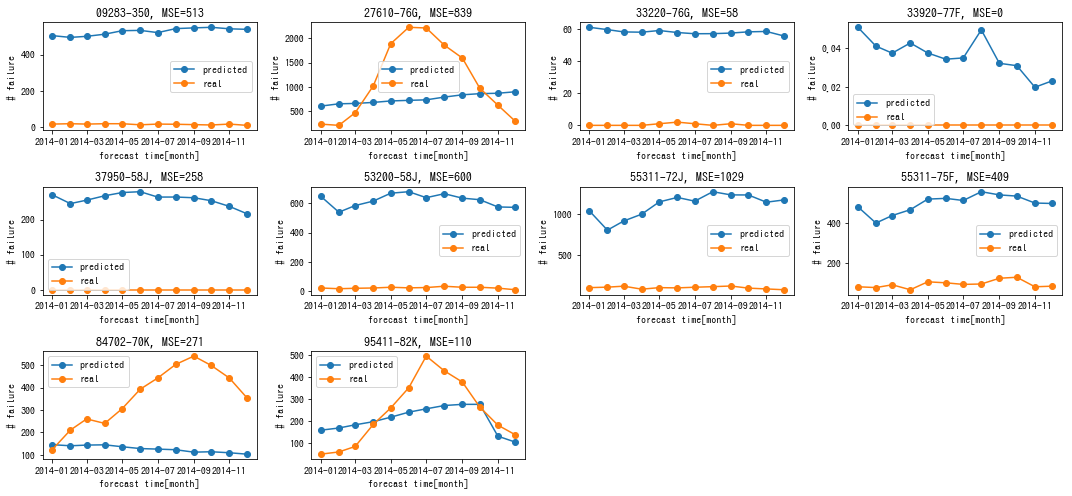

In [51]:
fig = plt.figure(figsize=(15,7))

for i, (part, row) in enumerate(df_np_pred.iterrows()):
    ax = fig.add_subplot(3,4,i+1)
    ax.plot(pd.date_range("2014-01-01","2014-12-01", freq="MS"), row, "o-", label="predicted")
    df_tmp = (df_warranty_parts.loc[df_warranty_parts.part_cd==part, ["date", "n"]]
              .set_index("date"))
    df_tmp = (pd.date_range("2014-01-01", "2014-12-01", freq="MS")
              .to_frame()
              .join(df_tmp)
              .drop([0], axis=1)
              .fillna(0))
    ax.plot(df_tmp, "o-", label="real")
    mse = np.sqrt(np.mean((df_tmp.values.ravel() - row.values.ravel())**2))
    ax.set(title=f"{part}, MSE={mse:.0f}", xlabel="forecast time[month]", ylabel="# failure")

    plt.legend()
plt.tight_layout()

- 季節性(27610-76G、84702-70K, 95411-82Kなど)は捉えにくい
- 09283-350, 53200-58Jなど、実際には殆どワランティが発生していないにも関わらず、高めに予測しているものがあった。既に対策が取られたパーツと思われる。
- 今回は2013年末に流通していたパーツのみを対象に予測を行ったが、将来の生産計画があれば、それも含めて故障数を予測することができるだろう。

#### 参考: 各パーツの2013年末時点の時間経過の分布

In [81]:
# 参考: 各パーツの
sql_month_passed = """
-- 生産テーブルから必要なデータを抽出し、FCOKを月単位にならす
with t_fcok as (
    select 
        to_date(substr(v_fcok, 1, 6), 'YYYYMM') as fcok_month
        ,substr(v_prod_model_cd, 1, 3) as model_code
        ,v_vin
    from fcok
    where v_base_cd = '100100'
        and v_prod_div = 'B'
        and v_spec = '000'
        and v_fcok not in ('20000100')
        and v_fcok < '{cutoff_date}'
)

-- ワランティテーブルから必要なデータを抽出し、パーツ番号を上5-3桁に切り取り、(VIN-パーツ番号)がユニークになるように
, t_warranty as (
    select 
        substr(w_causal_part_no, 1, 9) as causal_part
        ,max(to_date(w_process_month, 'YYYYMM')) as last_process_month
        ,w_vin
    from warranty
    where 
        W_SALES_DATE not in ({error_list_str_sales})
        and W_FAILURE_DATE not in ({error_list_str})
        and W_PROD_BASE_CD = '100100'
        and W_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
        and W_FIELD_CLAIM_DIV = '1'
        and to_date(w_process_month,'YYYYMM') < '{cutoff_date}'
    group by w_vin, causal_part
)

-- 抽出した生産テーブルとパーツ-モデルマスタデータから、対象パーツについて、生産された全パーツのテーブルを作成し、
-- さらに直近のワランティデータもleft join。生存期間も計算。
, term_all as (
    select
        t_fcok.model_code
        ,pm_master.causal_part
        ,last_process_month
        ,case when last_process_month is null then
            extract(year from age('{cutoff_date}', fcok_month))*12
                + extract(month from age('{cutoff_date}', fcok_month))
        else 
            extract(year from age('{cutoff_date}', last_process_month))*12
                    + extract(month from age('{cutoff_date}', last_process_month))
        end as month_passed
    from t_fcok
    join part_model_master as pm_master
        on pm_master.model_code = t_fcok.model_code
    left join t_warranty
        on pm_master.causal_part = t_warranty.causal_part
            and t_fcok.v_vin = t_warranty.w_vin
    where pm_master.causal_part in ({target_parts_str})
)

-- 算出した生存期間をパーツ毎に集計
select
    causal_part
    ,month_passed
    ,count(*) as n
from term_all
group by causal_part, month_passed
;""".format(cutoff_date=cutoff_date, error_list_str=error_list_str,
            error_list_str_sales=error_list_str_sales,
            target_parts_str=target_parts_str,
            sum_failure_part=sum_failure_part)

In [82]:
df_month_passed = pd.read_sql_query(sql_month_passed, engine)

In [80]:
df_month_passed.head()

,causal_part,month_passed,n
0,55311-72J,90.0,34792
1,09283-350,72.0,51831
2,53200-58J,32.0,21905
3,53200-58J,188.0,35
4,55311-75F,78.0,28160


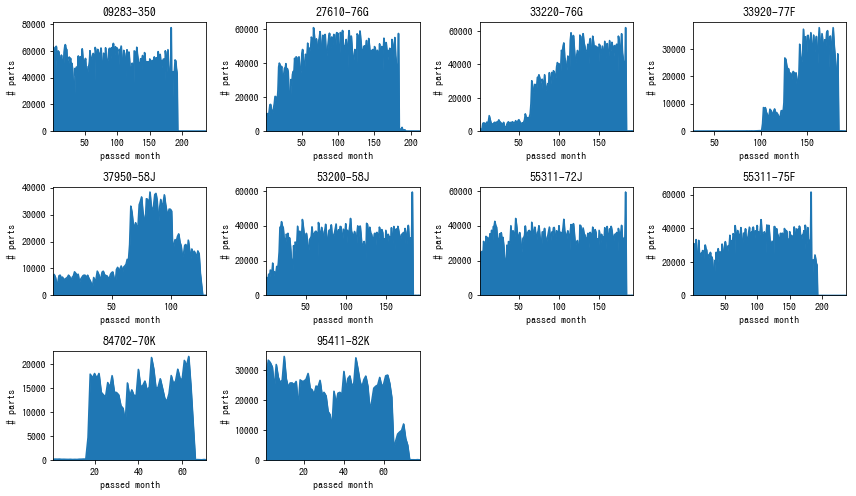

In [83]:
fig = plt.figure(figsize=(12,7))

for i, part in enumerate(df_np_pred.index):
    ax = fig.add_subplot(3,4,i+1)
    (df_month_passed[df_month_passed.causal_part==part]
     .set_index("month_passed")["n"]
     .sort_index()
     .plot(kind="area", ax=ax))
    ax.set(title=part, xlabel="passed month", ylabel="# parts")
plt.tight_layout()

### パラメトリックモデル

- パラメトリックモデルの良いところは、ノンパラメトリックモデルよりも少ないパラメータ数で、生存関数をモデリングできることである。
    - 例えば指数分布モデルであれば、パラメータ$\beta$(平均値の逆数)1個さえ推定できれば、生存関数を書くことができる。
    - ワイブル分布を使ったとしても、形状パラメータと尺度パラメータの2個さえ推定できれば良い。
- 結果、生存関数がワイブル分布にある程度従ってさえいれば、少数のサンプルでパラメータの推定が可能である。
    - この良さを生かして、例えば生産直後数ヶ月のデータのみを用いて、その後の生存関数を推定するような試みもある。
        - この予測が上手くいく場合、早期で開発部門などにフィードバックが可能となる。
        - 注意点としては、「生存関数が時期を問わず一定である」という仮定を置いていることである。すなわち、途中で設備変更などがあり、生存関数が変わってしまった場合は、当初推定したワイブル分布に生存関数が従うという保証はない。

#### 指数分布

ハザード関数が一定の値$\beta$とみなせる場合、指数分布は生存関数の良い近似となる。  
$$S(t) = exp(-\beta t)$$

特に摩耗や初期不良がなく、故障が"偶発的事象"とみなせる場合は、ハザード関数も一定の値になると期待できるので、指数分布が使用できる。  
指数分布はワイブル分布の一種とも捉えられるため(後述)、実務上、パラメトリックモデルを使用するときは、指数分布ではなくワイブル分布を使用することが多い。

#### ワイブル分布

次のような確率分布を、**ワイブル分布**と呼ぶ。

$$S(t) = exp(-\beta t^m)$$

ここで、$\beta$、$m$はともに0より大きい値を取るパラメータである。  
$m$は形状パラメータと呼ばれ、故障のタイプに応じて、以下のように変化する。
- m < 1 のとき、時間とともに故障率が小さくなる性質すなわち初期的な故障。
- m = 1 のとき、時間に対して故障率が一定となる性質すなわち偶発的な故障。
- m > 1 のとき、時間とともに故障率が大きくなる性質すなわち摩耗的な故障。

また、$m=1$のとき、ワイブル分布は指数分布と一致する。

他方、$\beta$は尺度パラメータと呼ばれ、平均的な故障までの期間に対応する(そのまま平均値になるわけではない)。

ハザード関数は次のような形を取る。
$$h(t)=\beta m t^{m-1}$$

また、このような書き方をする場合もある。
$$S(t) = exp(-\frac{t^m}{\lambda^m})$$
$$h(t)=\frac{1}{\lambda^m} m t^{m-1}$$

$\beta$を$\frac{1}{\lambda^m}$で置き換えただけなので、あまり変わらないが、図表がプロットしやすい。

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


Text(0.5, 1.0, 'Hazard rate of weibull model')

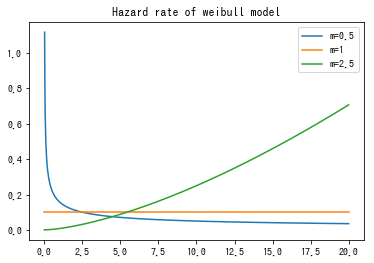

In [93]:
t = np.linspace(0,20, 1000)

lam = 10
for m in [0.5, 1, 2.5]:
    plt.plot(t, 1/(lam)**m * m * t**(m-1), label=f"m={m}")
plt.legend()
plt.title("Hazard rate of weibull model")

**問題**
- 初期不良、偶発的故障、摩耗性故障はどの線に対応するでしょうか？

Text(0.5, 1.0, 'Survival function of weibull model')

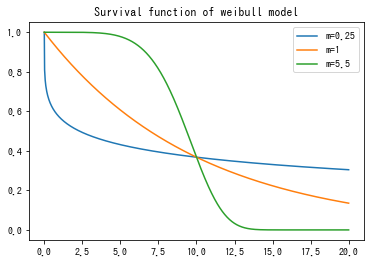

In [95]:

t = np.linspace(0,20, 1000)

lam = 10
for m in [0.25, 1, 5.5]:
    plt.plot(t, np.exp(-(t/lam)**m), label=f"m={m}")
plt.legend()
plt.title("Survival function of weibull model")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


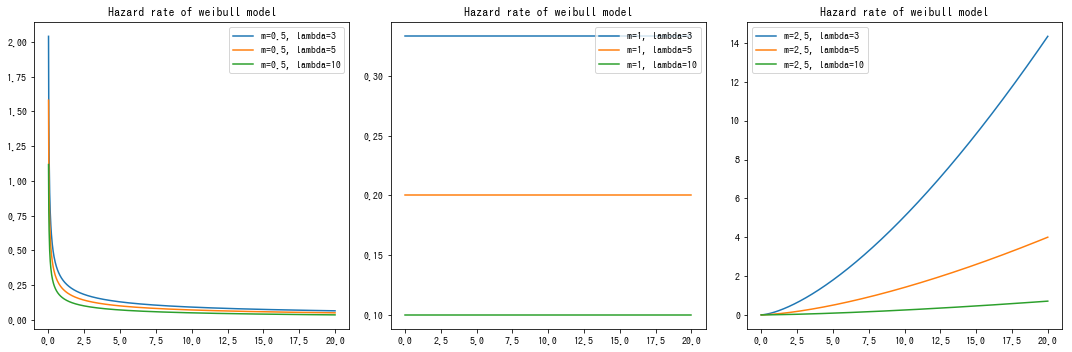

In [96]:
fig = plt.figure(figsize=(15,5))
for i,m in enumerate([0.5, 1, 2.5]):
    ax = fig.add_subplot(1,3,i+1)
    for lam in [3, 5, 10]:
        plt.plot(t, 1/(lam)**m * m * t**(m-1), label=f"m={m}, lambda={lam}")
    plt.legend()
    plt.title("Hazard rate of weibull model")
plt.tight_layout()

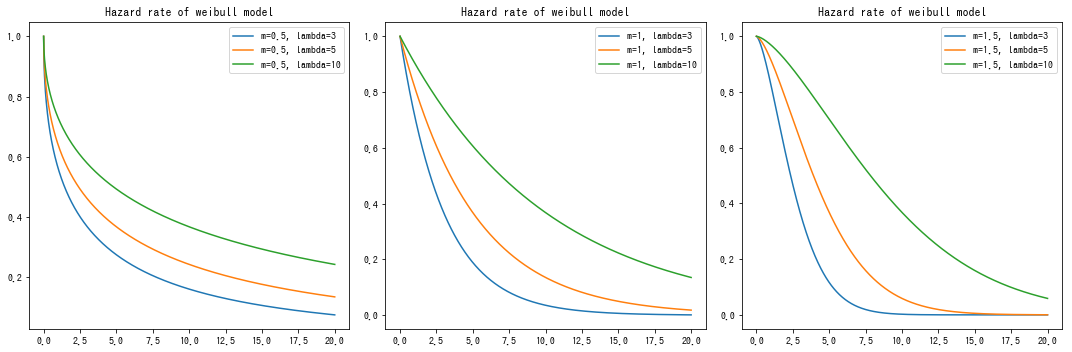

In [97]:
fig = plt.figure(figsize=(15,5))
for i,m in enumerate([0.5, 1, 1.5]):
    ax = fig.add_subplot(1,3,i+1)
    for lam in [3, 5, 10]:
        plt.plot(t, np.exp(-(t/lam)**m), label=f"m={m}, lambda={lam}")
    plt.legend()
    plt.title("Hazard rate of weibull model")
plt.tight_layout()

#### ワイブル・プロット

ワイブル分布のパラメータ推定であるが、最尤推定とワイブル・プロットが一般的である。ここではワイブル・プロットについて解説する。  
ワイブル・プロットはプロットの傾きから$m$を算出し、その後$\lambda$を計算する方法である。  
傾きを最小二乗法で出しているため統計的見地からは厳密さに欠けるが、簡便な方法であり、良く用いられる。

先程述べたように、ワイブル分布はこのように書けるが、
$$S(t) = exp(-\frac{t^m}{\lambda^m})$$

これは以下のように式変形できる。
$$\ln \left\{\ln {\frac {1}{S(t)}}\right\}=m\ln t-m\ln \lambda$$

これは、$Y=\ln \left(\ln {\frac {1}{S(t)}}\right)$, $X=\ln t$と置くと、以下のように書ける。
$$Y = m X - m \ln \lambda$$

なので、横軸を経過期間$t$の対数、縦軸を生存関数の逆数の対数の更に対数として取るようなプロットを描き、その傾きの値を推定することで、$m$の値を推定できる。このようなプロットを、**ワイブル・プロット**と呼ぶ。

なお、$$S(t) = exp\left(-H(t)\right)$$であるから、よりシンプルに$$\ln H(t) = m \ln t - m \ln \lambda$$

とも書ける。すなわち、累積ハザード関数$H(t)$と経過期間$t$の両対数プロットの傾きから、$m$の値を推定できる。  
こちらのプロットは、累積ハザード法によるワイブル・プロット、と呼ばれることがある。

まずは、ワイブル・プロットを描写する。ここで、対数を取る際に、tで0があると対数が定義できないので、tに1を加える。  
すなわち、今までは同月に交換or販売と故障があった場合は$t=0$、1年後同月に故障があった場合は$t=12$とみなしていたが、これをそれぞれ$t=1$、$t=13$とみなすことを意味する。今までの36ヶ月(3年後同月)のピークは、37ヶ月に移ることに留意。

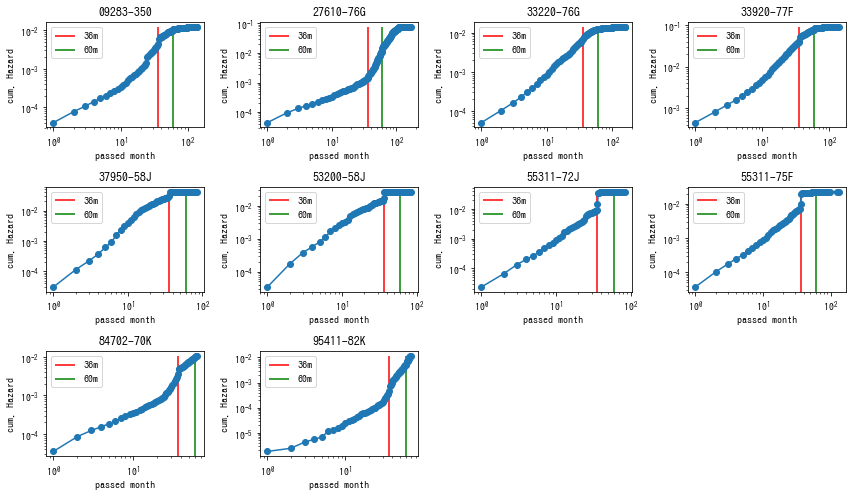

In [52]:
fig = plt.figure(figsize=(12,7))

for i, part in enumerate(df_np_pred.index):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = (survival_table[survival_table.causal_part==part]
             .set_index("month_passed")["cum_hazard"]
             .sort_index())
    plt.plot(df_tmp.index + 1, df_tmp.values, "o-")
    plt.vlines(36, 0, max(df_tmp), color="red", label="36m") # 赤線(36ヶ月)
    plt.vlines(60, 0, max(df_tmp), color="green", label="60m") # 緑線(60ヶ月)
    ax.set(title=part, xlabel="passed month", ylabel="cum. Hazard")
    ax.semilogy() # yを対数に
    ax.semilogx() # xを対数に
    plt.legend()
plt.tight_layout()

- 36ヶ月を境に累積ハザードレートの上昇率が変化するものが多い。
- 36ヶ月の数ヶ月前から傾きが変化するものもある。(84702-70Kなど)

新しい定義で36ヶ月まで(3年後同月の前月の故障まで)のデータを用いて、回帰を行い、パラメータを推定する。

In [53]:
from scipy.stats import linregress # 線形回帰用の関数

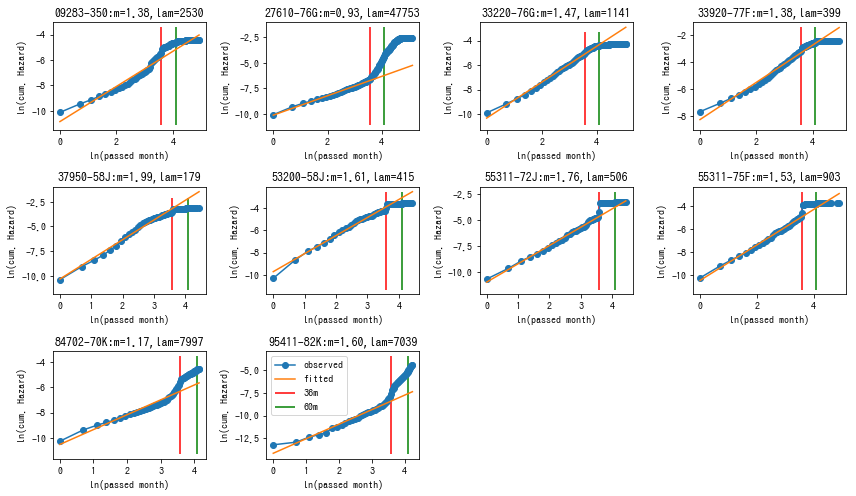

In [54]:
fig = plt.figure(figsize=(12,7))
m_dict, int_dict = {}, {} # 傾きと切片の入れ物

for i, part in enumerate(df_np_pred.index):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = (survival_table[survival_table.causal_part==part]
             .set_index("month_passed")["cum_hazard"]
             .sort_index()
             .dropna())
    x = np.log(df_tmp.index.values + 1) # xを対数に変換
    y = np.log(df_tmp.values) # yを対数に変換
    ax.plot(x, y, "o-", label="observed")
    ax.vlines(np.log(36), min(y)-1, max(y)+1, color="red", label="36m") # 赤線(36ヶ月)
    ax.vlines(np.log(60), min(y)-1, max(y)+1, color="green", label="60m") # 緑線(60ヶ月)
    slope, intercept, *_ = linregress(x[:36], y[:36]) # 線形回帰
    m_dict[part], int_dict[part] = slope, intercept # 傾きと切片を入れ物に入れる
    lam = np.exp(-intercept / slope) # lambdaを計算
    y_reg = x * slope + intercept # 線形回帰結果からの予測値を計算
    ax.plot(x, y_reg, "-", label="fitted") # 線形回帰結果からの予測値をプロット
    ax.set(title=part + f":m={slope:.2f},lam={lam:.0f}",
           xlabel="ln(passed month)", ylabel="ln(cum. Hazard)")
    
plt.legend()
plt.tight_layout()

今回対象のパーツ群では、いずれもm(傾き)が1より大きかったが、これはハザード関数のプロットにおいて、初期不良型のハザード関数(最初に最も故障が多く、徐々に減少する)を取るパーツがなかったことと整合的である。

また、最初の4ヶ月(4点)でどの程度のモデリングができるかも見てみる。

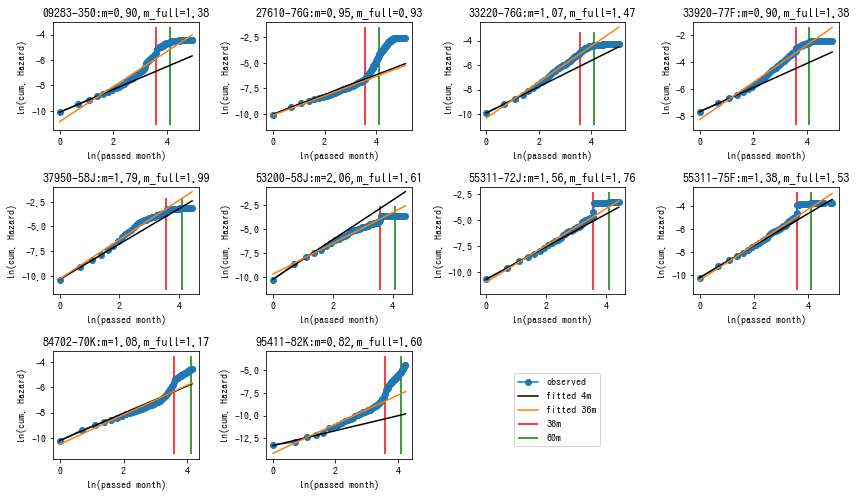

In [55]:
fig = plt.figure(figsize=(12,7))

for i, part in enumerate(df_np_pred.index):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = (survival_table[survival_table.causal_part==part]
             .set_index("month_passed")["cum_hazard"]
             .sort_index()
             .dropna())
    x = np.log(df_tmp.index.values + 1)
    y = np.log(df_tmp.values)
    ax.plot(x, y, "o-", label="observed")
    ax.vlines(np.log(36), min(y)-1, max(y)+1, color="red", label="36m")
    ax.vlines(np.log(60), min(y)-1, max(y)+1, color="green", label="60m")
    slope, intercept, *_ = linregress(x[:4], y[:4]) # 最初の4ヶ月分のみ使用
    lam = np.exp(-intercept / slope)
    y_reg = x * slope + intercept
    y_reg_full = x * m_dict[part] + int_dict[part]
    ax.plot(x, y_reg, "-", label="fitted 4m", color="black")
    ax.plot(x, y_reg_full, "-", label="fitted 36m")
    ax.set(title=part + f":m={slope:.2f},m_full={m_dict[part]:.2f}",
           xlabel="ln(passed month)", ylabel="ln(cum. Hazard)")

handles,labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.6, 0.1), ncol=1)
plt.tight_layout()

初めの数ヶ月で比較的良く推定できているものが多いが、09283-350, 95411-82Kなど、途中で傾きが変化するものは難しい。  

#### 予測

回帰を行い、予測テーブルを作る。以下の2通りを試してみる。
1. いくつかの期間に分けて推定する場合
2. 初めの4ヶ月のデータで推定する場合

##### 方法1

ここでは、再帰的に区間を分割していく。ただし、データを細かくすればするほど、常に尤度は改善するので、ベイズ情報量基準が改善するときのみ、区間を分割するようにする。  

ちなみに、教師あり学習の一つであり、ランダムフォレストや勾配ブースティングのベースとなる**決定木**も、同じようなアルゴリズムで実装されている。  

In [56]:
import statsmodels.api as sm # statsmodelsは線形回帰時に尤度を計算してくれる。

In [57]:
def split_data(x, y, total_n_sample, min_length = 4, coef=1):
    gain_dict = {}
    if len(x) >= min_length*2: # 長さが足りないときは、分割の対象としない。
        for i in range(min_length, len(x)-min_length+1): # 区切る場所を虱潰しに探す
            x_left, y_left = x[:i], y[:i] # 分割(左側)
            x_right, y_right = x[i:], y[i:] # 分割(右側)
            lm_all = sm.OLS(y, sm.add_constant(x)).fit() # 全体で回帰
            lm_left = sm.OLS(y_left, sm.add_constant(x_left)).fit() # 左側を回帰
            lm_right = sm.OLS(y_right, sm.add_constant(x_right)).fit() # 右側を回帰
            loglikelihood_all = lm_all.llf # 全体を1個のモデルとしたときの尤度
            loglikelihood_splitted = lm_left.llf + lm_right.llf # 分けたときの尤度
            gain_dict[i] = 2 * loglikelihood_splitted - 2 * loglikelihood_all # 分割による尤度の上昇幅
        
        best_i = sorted(gain_dict.items(), key=lambda x:x[1], reverse=True)[0][0] # 最も上昇幅の大きい分割点
        
        # 上昇幅がパラメータ数増加のペナルティより大きいときは、分割する。
        if gain_dict[best_i] >= 3 * np.log(total_n_sample) * coef: 
            return split_data(x[:best_i], y[:best_i], total_n_sample, min_length, coef) + \
                   split_data(x[best_i:], y[best_i:], total_n_sample, min_length, coef)
        else: # そうでないときはそのまま
            return [(x, y)]
    else: # 長さが足りないときも、そのまま
        return [(x,y)]

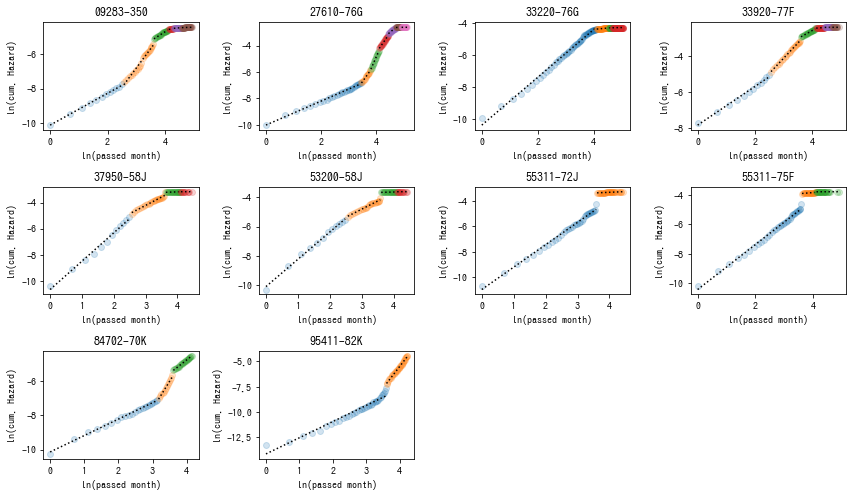

In [58]:
fig = plt.figure(figsize=(12,7))
s_dict_1 = {}

for i, part in enumerate(df_np_pred.index):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = (survival_table[survival_table.causal_part==part]
             .set_index("month_passed")["cum_hazard"]
             .sort_index()
             .dropna())
    x = np.log(df_tmp.index.values + 1)
    y = np.log(df_tmp.values)
    
    # パラメータ増加によるペナルティを5倍強めにかけ、最小区間を12ヶ月とすると、見た目としてちょうど良さそうな結果となった
    df_tmp_splitted = split_data(x, y, len(x), coef=5, min_length=12)
    s_list = [] # モデリングされた生存関数の入れ物
    
    for x_i, y_i in df_tmp_splitted: # splid_dataによって分割された各区間について、処理
        ax.plot(x_i, y_i, "o", alpha=0.2)
        slope, intercept, *_ = linregress(x_i, y_i) # 線形回帰
        lam = np.exp(-intercept / slope) # lambdaを計算
        s = pd.Series(np.exp(- (np.exp(x_i)**slope) / (lam**slope)),
                      index=np.round(np.exp(x_i) - 1, 0).astype(int)) # モデリング結果の生存関数を計算
        s_list.append(s) # 入れ物に追加
        ax.plot(x_i, x_i * slope + intercept, "k:")
    ax.set(title=part, xlabel="ln(passed month)", ylabel="ln(cum. Hazard)")
    s_dict_1[part] = pd.concat(s_list)
    
plt.tight_layout()

In [59]:
# 各経過月数の各パーツに対して、1ヶ月後 ~ 12ヶ月後の故障確率を計算
surv_pred_table_w_1 = (pd.DataFrame(s_dict_1)
         .unstack()
         .dropna()
         .to_frame(name="survival_function")
         .reset_index()
         .rename(columns={"level_0":"causal_part", "level_1":"month_passed"})
         .sort_values(by=["causal_part", "month_passed"]))

for i in range(1,13): # 1,2,..,12
    surv_pred_table_w_1[f"fail_rate_{i}"] = 1- (surv_pred_table_w_1
                                            .groupby("causal_part")["survival_function"]
                                            .shift(-i) /
                                            surv_pred_table_w_1["survival_function"]
                                            )

In [60]:
surv_pred_table_w_1.head()

,causal_part,month_passed,survival_function,fail_rate_1,fail_rate_2,fail_rate_3,fail_rate_4,fail_rate_5,fail_rate_6,fail_rate_7,fail_rate_8,fail_rate_9,fail_rate_10,fail_rate_11,fail_rate_12
0,09283-350,0,0.999960,0.000036,0.000070,0.000104,0.000137,0.000170,0.000202,0.000234,0.000266,0.000297,0.000328,0.000359,0.000377
1,09283-350,1,0.999925,0.000035,0.000068,0.000101,0.000134,0.000166,0.000198,0.000230,0.000261,0.000292,0.000323,0.000342,0.000418
2,09283-350,2,0.999890,0.000034,0.000067,0.000099,0.000132,0.000164,0.000195,0.000227,0.000258,0.000289,0.000307,0.000383,0.000466
3,09283-350,3,0.999856,0.000033,0.000066,0.000098,0.000130,0.000162,0.000193,0.000224,0.000255,0.000273,0.000349,0.000433,0.000523
4,09283-350,4,0.999823,0.000033,0.000065,0.000097,0.000128,0.000160,0.000191,0.000222,0.000240,0.000316,0.000399,0.000490,0.000588


In [61]:
# 分けてフィッティングしているため、データがない部分でマイナスが生じている。0に変更
for col in surv_pred_table_w_1.columns[2:]:
    surv_pred_table_w_1.loc[surv_pred_table_w_1[col] <0, col] = 0

In [63]:
# 60を超えたパーツについては、fail_rate=0とする。(パーツによっては36でも良いかもしれないが、一旦60で。)
surv_pred_table_w_1.loc[surv_pred_table_w_1.month_passed >= 60, 
                    [c for c in surv_pred_table_w_1.columns if "fail" in c]] = 0


# databaseのテーブルに書き込み
(surv_pred_table_w_1
 .drop("survival_function", axis=1)
 .reset_index(drop=True)
 .to_sql("survival_np_ut2013_w_1", con=engine, index=False, if_exists="replace"))

In [65]:
sql_np_pred_w_1 = gen_sql_np_pred(cutoff_date=cutoff_date, error_list_str=error_list_str,
                error_list_str_sales=error_list_str_sales,
                target_parts_str=target_parts_str,
                sum_failure_part=sum_failure_part, survival_table="survival_np_ut2013_w_1")

In [67]:
%%time
df_np_pred_w_1 = pd.read_sql_query(sql_np_pred_w_1, engine)

CPU times: user 10.4 ms, sys: 11.5 ms, total: 21.9 ms
Wall time: 4min 35s


In [68]:
df_np_pred_w_1

,causal_part,n_fail_1,n_fail_2,n_fail_3,n_fail_4,n_fail_5,n_fail_6,n_fail_7,n_fail_8,n_fail_9,n_fail_10,n_fail_11,n_fail_12
0,09283-350,507.729486,983.155653,1477.202050,1981.637827,2506.153326,3039.891047,3567.970299,4113.590563,4660.541464,5214.028029,5760.454271,6311.079460
1,27610-76G,593.404367,1232.391811,1885.299608,2564.764659,3276.547858,4009.869632,4758.426651,5559.135697,6403.596874,7273.616057,8158.429984,9074.465069
2,33220-76G,70.720625,135.450537,197.924640,258.648588,318.236957,376.044455,434.323585,492.775200,547.781197,600.042855,651.974778,705.310016
3,33920-77F,0.047488,0.086356,0.126821,0.173073,0.207909,0.241700,0.275250,0.314511,0.350142,0.379369,0.399529,0.421978
4,37950-58J,263.358399,534.165520,783.206497,1037.413653,1301.689422,1567.284959,1833.569925,2086.656721,2344.768418,2599.089750,2842.396383,3058.112012
5,53200-58J,683.902320,1221.680796,1806.766209,2405.402455,3058.285448,3739.336871,4369.019138,5046.618062,5686.026482,6325.612359,6903.780640,7480.094746
6,55311-72J,1085.514401,1816.502713,2686.079547,3616.776359,4719.589712,5937.526015,7065.661405,8341.657247,9558.130875,10810.834146,11949.825042,13075.208331
7,55311-75F,509.028133,890.530947,1320.927511,1770.560261,2288.207632,2816.379302,3314.997459,3875.728970,4410.171278,4948.673792,5442.353789,5937.416117
8,84702-70K,144.446967,282.714180,428.716407,561.513808,689.524715,815.615370,936.901540,1052.562823,1166.850843,1281.205559,1385.392565,1478.989577
9,95411-82K,160.131976,325.277519,503.690001,694.551364,900.710139,1121.049912,1355.243656,1606.958764,1873.559814,2019.564861,2135.202972,2254.505844


In [69]:
df_np_pred_w_1.set_index("causal_part", inplace=True) # パーツ名をindexに

# 並び替える(10や11の順番がおかしくなっているので)
df_np_pred_w_1 = df_np_pred_w_1[['n_fail_1', 'n_fail_2', 'n_fail_3', 'n_fail_4', 
                         'n_fail_5', 'n_fail_6', 'n_fail_7', 'n_fail_8',
                         'n_fail_9', 'n_fail_10', 'n_fail_11', 'n_fail_12']] 

# 毎月の差分を計算
for i in range(2,13):
    df_np_pred_w_1[f"n_fail_month_{i}"] = (df_np_pred_w_1[f"n_fail_{i}"] - 
                                       df_np_pred_w_1[f"n_fail_{i-1}"])

df_np_pred_w_1 = df_np_pred_w_1.drop([f"n_fail_{i}" for i in range(2,13)], axis=1)

df_np_pred_w_1.columns = ['n_fail_month_1', 'n_fail_month_2', 'n_fail_month_3', 'n_fail_month_4',
       'n_fail_month_5', 'n_fail_month_6', 'n_fail_month_7', 'n_fail_month_8',
       'n_fail_month_9', 'n_fail_month_10', 'n_fail_month_11',
       'n_fail_month_12']

##### 方法2

In [71]:
s_dict_2 = {}

for part in df_np_pred.index:
    df_tmp = (survival_table[survival_table.causal_part==part]
             .set_index("month_passed")["cum_hazard"]
             .sort_index()
             .dropna())
    x = np.log(df_tmp.index.values + 1)
    y = np.log(df_tmp.values)
    slope, intercept, *_ = linregress(x[:4], y[:4])
    lam = np.exp(-intercept / slope)
    y_reg = x * slope + intercept
    s = pd.Series(np.exp(-(np.exp(x)**slope)/(lam**slope)),
                  index=np.round(np.exp(x),0).astype(int))
    s_dict_2[part] = s

In [72]:
# 各経過月数の各パーツに対して、1ヶ月後 ~ 12ヶ月後の故障確率を計算
surv_pred_table_w_2 = (pd.DataFrame(s_dict_2)
         .unstack()
         .dropna()
         .to_frame(name="survival_function")
         .reset_index()
         .rename(columns={"level_0":"causal_part", "level_1":"month_passed"}))

for i in range(1,13): # 1,2,..,12
    surv_pred_table_w_2[f"fail_rate_{i}"] = 1- (surv_pred_table_w_2
                                            .groupby("causal_part")["survival_function"]
                                            .shift(-i) /
                                            surv_pred_table_w_2["survival_function"]
                                            )

In [73]:
# 60を超えたパーツについては、fail_rate=0とする。(パーツによっては36でも良いかもしれないが、一旦60で。)
surv_pred_table_w_2.loc[surv_pred_table_w_2.month_passed >= 60, 
                    [c for c in surv_pred_table_w_2.columns if "fail" in c]] = 0

# databaseのテーブルに書き込み
(surv_pred_table_w_2
 .drop("survival_function", axis=1)
 .reset_index(drop=True)
 .to_sql("survival_np_ut2013_w_2", if_exists="replace", con=engine, index=False))

In [80]:
surv_pred_table_w_2.head()

,causal_part,month_passed,survival_function,fail_rate_1,fail_rate_2,fail_rate_3,fail_rate_4,fail_rate_5,fail_rate_6,fail_rate_7,fail_rate_8,fail_rate_9,fail_rate_10,fail_rate_11,fail_rate_12
0,09283-350,1,0.999959,0.000035,0.000069,0.000101,0.000133,0.000164,0.000194,0.000225,0.000254,0.000284,0.000313,0.000341,0.000370
1,09283-350,2,0.999924,0.000034,0.000066,0.000098,0.000129,0.000159,0.000189,0.000219,0.000248,0.000277,0.000306,0.000335,0.000363
2,09283-350,3,0.999890,0.000032,0.000064,0.000095,0.000126,0.000156,0.000185,0.000215,0.000244,0.000273,0.000301,0.000329,0.000358
3,09283-350,4,0.999858,0.000032,0.000063,0.000093,0.000123,0.000153,0.000182,0.000211,0.000240,0.000269,0.000297,0.000325,0.000353
4,09283-350,5,0.999826,0.000031,0.000061,0.000092,0.000121,0.000151,0.000180,0.000208,0.000237,0.000265,0.000294,0.000322,0.000349


In [74]:
sql_np_pred_w_2 = gen_sql_np_pred(cutoff_date=cutoff_date, error_list_str=error_list_str,
                error_list_str_sales=error_list_str_sales,
                target_parts_str=target_parts_str,
                sum_failure_part=sum_failure_part, survival_table="survival_np_ut2013_w_2")

In [75]:
%%time
df_np_pred_w_2 = pd.read_sql_query(sql_np_pred_w_2, engine)

CPU times: user 10.3 ms, sys: 10.3 ms, total: 20.6 ms
Wall time: 4min 23s


In [76]:
df_np_pred_w_2.set_index("causal_part", inplace=True) # パーツ名をindexに

# 並び替える(10や11の順番がおかしくなっているので)
df_np_pred_w_2 = df_np_pred_w_2[['n_fail_1', 'n_fail_2', 'n_fail_3', 'n_fail_4', 
                         'n_fail_5', 'n_fail_6', 'n_fail_7', 'n_fail_8',
                         'n_fail_9', 'n_fail_10', 'n_fail_11', 'n_fail_12']] 

# 毎月の差分を計算
for i in range(2,13):
    df_np_pred_w_2[f"n_fail_month_{i}"] = (df_np_pred_w_2[f"n_fail_{i}"] - 
                                       df_np_pred_w_2[f"n_fail_{i-1}"])

df_np_pred_w_2 = df_np_pred_w_2.drop([f"n_fail_{i}" for i in range(2,13)], axis=1)

df_np_pred_w_2.columns = ['n_fail_month_1', 'n_fail_month_2', 'n_fail_month_3', 'n_fail_month_4',
       'n_fail_month_5', 'n_fail_month_6', 'n_fail_month_7', 'n_fail_month_8',
       'n_fail_month_9', 'n_fail_month_10', 'n_fail_month_11',
       'n_fail_month_12']

In [81]:
df_np_pred_w_2.head()

,n_fail_month_1,n_fail_month_2,n_fail_month_3,n_fail_month_4,n_fail_month_5,n_fail_month_6,n_fail_month_7,n_fail_month_8,n_fail_month_9,n_fail_month_10,n_fail_month_11,n_fail_month_12
causal_part,,,,,,,,,,,,
09283-350,82.419143,81.810544,81.303775,80.858905,80.457813,80.090178,79.749365,79.430771,79.131025,78.847558,78.578354,78.321794
27610-76G,66.529796,66.392487,66.267885,66.152021,66.042936,65.939431,65.840685,65.746092,65.655184,65.567590,65.483002,65.401164
33220-76G,19.192480,19.252449,19.307605,19.359173,19.407830,19.454027,19.498093,19.540277,19.580779,19.619764,19.657366,19.693701
33920-77F,0.008439,0.008418,0.008397,0.008377,0.008358,0.008338,0.008320,0.008301,0.008283,0.008265,0.008248,0.008231
37950-58J,353.853151,363.046223,372.082837,380.984272,389.763879,398.431149,420.538462,446.195573,456.562393,520.221215,558.630004,565.052296


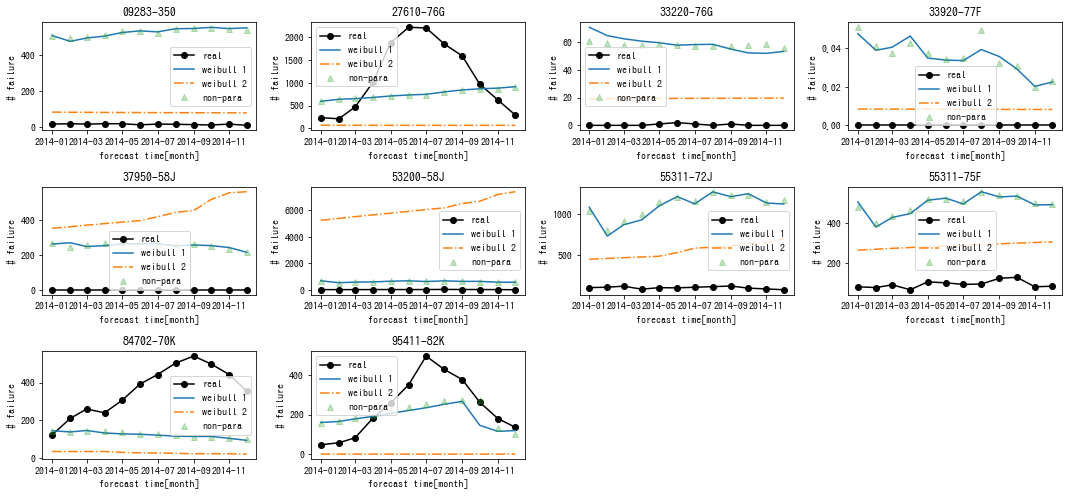

In [82]:
fig = plt.figure(figsize=(15,7))

for i, (part, row) in enumerate(df_np_pred_w_1.iterrows()):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = (df_warranty_parts.loc[df_warranty_parts.part_cd==part, ["date", "n"]]
              .set_index("date"))
    df_tmp = (pd.date_range("2014-01-01", "2014-12-01", freq="MS")
              .to_frame()
              .join(df_tmp)
              .drop([0], axis=1)
              .fillna(0))
    ax.plot(df_tmp, "ko-", label="real")
    
    ax.plot(pd.date_range("2014-01-01","2014-12-01", freq="MS"), row, "-", label="weibull 1")
    ax.plot(pd.date_range("2014-01-01","2014-12-01", freq="MS"),
            df_np_pred_w_2.loc[part,:], "-.", label="weibull 2")
    ax.plot(pd.date_range("2014-01-01","2014-12-01", freq="MS"), 
            df_np_pred.loc[part,:], "^", label="non-para", alpha=0.3)

    ax.set(title=part, xlabel="forecast time[month]", ylabel="# failure")
    plt.legend()
plt.tight_layout()

- ワイブル分布方法1では、ほぼ元々の関数の形を再現できているため、殆どノンパラメトリックでの結果と変わらない
- ワイブル分布方法2(最初の4ヶ月のみ使用)は、元々の関数とはズレがあるため、ワイブル分布方法1やノンパラメトリックからは異なる。今回のケースでは、初期不良が小さく、徐々に故障が増えていくパターンが多かったため、小さめに見積もられている。
- いずれの方法も、95411-82Kなど一部の例を除くと、実際の値とはかなり乖離がある。

#### (Optional)ワイブル分布の最尤推定

ここでは、$\lambda$ではなく$\beta$を使った方のパラメータ推定方法について扱う。式変形の後、対数尤度として次を得る。
$$log(L) = m \cdot log(\beta m) + (m-1)\sum_{i=1}^n \delta_i log(t_i) - \lambda \sum_{i=1}^n t_i^m$$

ここで、$\delta_i$は$i$番目のサンプルが打ち切りの場合は0、非打ち切りの場合に1となる変数である。

これは上に凸の関数となるので、これを微分して0と置くことで、最終的にmについて次の非線形方程式を得る。ただし、$r$は非打ち切りのサンプル数。
$$\frac{r}{m} + \sum_{i=1}^n \delta_i log(t_i) - \frac{r}{\sum_{i=1}^n t_i^m}\sum_{i=1}^n t_i^m log(t_i) = 0$$

この式から数値計算によってmを求めたのち、次の式から$\beta$を得る。
$$\beta = \frac{r}{\sum_{i=1}^n t_i^m}$$

In [406]:
survival_table.head()

,causal_part,month_passed,n_event,cutoff,total,sample_decrease,n_at_risk,survive_ratio,survival_function,term_length,hazard_rate,cum_hazard
0,09283-350,0.0,288.0,8.0,7117395.0,0.0,7117395.0,0.999960,0.999960,1.0,0.000040,0.000040
1,09283-350,1.0,264.0,58406.0,7117395.0,296.0,7117099.0,0.999963,0.999922,1.0,0.000037,0.000078
2,09283-350,2.0,220.0,62908.0,7117395.0,58670.0,7058429.0,0.999969,0.999891,1.0,0.000031,0.000109
3,09283-350,3.0,231.0,59147.0,7117395.0,63128.0,6995301.0,0.999967,0.999858,1.0,0.000033,0.000142
4,09283-350,4.0,202.0,56647.0,7117395.0,59378.0,6935923.0,0.999971,0.999829,1.0,0.000029,0.000171


In [83]:
# mについての非線形方程式
def value_to_zero(df, m):
    r = df["n_event"].sum()
    v_t = df["month_passed"]+1
    
    res = (r / m 
     + sum(np.log(v_t) * df["n_event"])
     - r / sum((v_t**m) * (df["n_event"]+df["cutoff"]))
     * sum((v_t**m) * np.log(v_t) * (df["n_event"]+df["cutoff"])))
    return res

In [84]:
# 55311-72Jの、経過期間 ~ 34ヶ月までのデータで最尤推定
df_tmp = survival_table[(survival_table.causal_part=="55311-72J") & 
                             (survival_table.month_passed <= 34)].copy()
df_tmp.loc[df_tmp.month_passed==34,"cutoff"] = (df_tmp.loc[df_tmp.month_passed==34,"n_at_risk"] - 
                                            df_tmp.loc[df_tmp.month_passed==34,"n_event"])

In [86]:
from scipy import optimize # newton-raphsonアルゴリズム(式評価結果が0となる点を数値的に探索するアルゴリズム)
m = optimize.newton(lambda x: value_to_zero(df_tmp, x), 1)
m

1.8594404458634646

ワイブル・プロットでは1.53近辺だったので、近い値だが、やや傾きが大きめの値となった。

In [97]:
beta = df_tmp["n_event"].sum() / sum((df_tmp["month_passed"]+1)**m * (df_tmp["n_event"] + df_tmp["cutoff"]))
# lambdaに換算
lam = (1/beta)**(1/m)
lam

439.0748585157676

Text(0, 0.5, 'survival function')

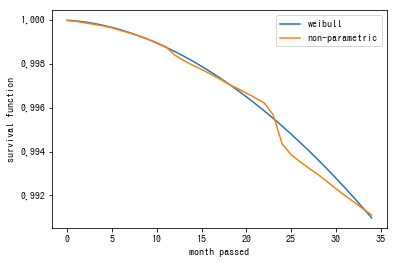

In [103]:
s = pd.Series(np.exp(-(df_tmp["month_passed"].values+1)**m / lam**m), index=df_tmp["month_passed"].values)
plt.plot(s, label="weibull")
plt.plot(df_tmp["month_passed"], df_tmp["survival_function"].values, label="non-parametric")
plt.legend()
plt.xlabel("month passed")
plt.ylabel("survival function")

### 参考: 故障までの期間

pパーセントが故障するまでの期間(期間のpパーセンタイル)は
$$\left(\frac{1}{\beta} \ln \left(\frac{100}{100-p}\right) \right)^{\frac{1}{m}}$$
または$\lambda$を用いて
$$\lambda \ln \left(\frac{100}{100-p}\right) ^{\frac{1}{m}}$$
で計算できる。

たとえば、55311-72Jが10%故障するまでの期間であれば、最尤推定のパラメータを用いれば(ワイブルプロットのパラメータでも良い)、

In [105]:
lam * np.log(100/(100-10))**(1/m)

130.89964082151553

130ヶ月(11年間)で10%が故障する

### 参考: lifelinesの使い方

In [106]:
from lifelines import WeibullFitter

In [107]:
survival_table.head()

,causal_part,month_passed,n_event,cutoff,total,sample_decrease,n_at_risk,survive_ratio,survival_function,term_length,hazard_rate,cum_hazard
0,09283-350,0.0,288.0,8.0,7117395.0,0.0,7117395.0,0.999960,0.999960,1.0,0.000040,0.000040
1,09283-350,1.0,264.0,58406.0,7117395.0,296.0,7117099.0,0.999963,0.999922,1.0,0.000037,0.000078
2,09283-350,2.0,220.0,62908.0,7117395.0,58670.0,7058429.0,0.999969,0.999891,1.0,0.000031,0.000109
3,09283-350,3.0,231.0,59147.0,7117395.0,63128.0,6995301.0,0.999967,0.999858,1.0,0.000033,0.000142
4,09283-350,4.0,202.0,56647.0,7117395.0,59378.0,6935923.0,0.999971,0.999829,1.0,0.000029,0.000171


In [108]:
tmp = df_tmp.copy()

In [109]:
tmp.tail()

,causal_part,month_passed,n_event,cutoff,total,sample_decrease,n_at_risk,survive_ratio,survival_function,term_length,hazard_rate,cum_hazard
756,55311-72J,30.0,474.0,33358.0,2344188.0,30286.0,1398355.0,0.999661,0.992307,1.0,0.000339,0.007721
757,55311-72J,31.0,418.0,28891.0,2344188.0,33832.0,1364523.0,0.999694,0.992003,1.0,0.000306,0.008028
758,55311-72J,32.0,395.0,22188.0,2344188.0,29309.0,1335214.0,0.999704,0.991709,1.0,0.000296,0.008323
759,55311-72J,33.0,411.0,19814.0,2344188.0,22583.0,1312631.0,0.999687,0.991399,1.0,0.000313,0.008637
760,55311-72J,34.0,374.0,1292032.0,2344188.0,20225.0,1292406.0,0.999711,0.991112,1.0,0.000289,0.008926


In [110]:
# lifelinseのインプット形式のデータを作成
import itertools

ll_data_e_cut = list(itertools.chain.from_iterable(
    [[0] * int(n_c) for n_c in tmp.cutoff]))
ll_data_t_cut = list(itertools.chain.from_iterable(
    [[t] * int(n_c) for t, n_c in zip(tmp.month_passed, tmp.cutoff)]))

ll_data_e_event = list(itertools.chain.from_iterable(
    [[1] * int(n_c) for n_c in tmp.n_event]))
ll_data_t_event = list(itertools.chain.from_iterable(
    [[t] * int(n_c) for t, n_c in zip(tmp.month_passed, tmp.n_event)]))

ll_data_e = np.array(ll_data_e_cut + ll_data_e_event)
ll_data_t = np.array(ll_data_t_cut + ll_data_t_event)

In [111]:
ll_data_t[:5]

array([0., 0., 0., 0., 0.])

In [112]:
ll_data_e[:5]

array([0, 0, 0, 0, 0])

In [113]:
len(ll_data_e)

2344188

In [114]:
(tmp.n_event + tmp.cutoff).sum()

2344188.0

In [115]:
# 使い方はscikit-learnに似ている。インスタンスをつくり、fit(time, event(0 or 1))でフィット
wf = WeibullFitter()
wf = wf.fit(ll_data_t + 1, ll_data_e)

<lifelines.WeibullFitter: fitted with 2344188 observations, 2329018 censored>
number of subjects = 2344188
  number of events = 15170
    log-likelihood = -139189.893
        hypothesis = lambda_ != 1, rho_ != 1

---
          coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda_ 439.17      8.82      421.88      456.45 <0.005       inf
rho_      1.86      0.01        1.83        1.89 <0.005       inf


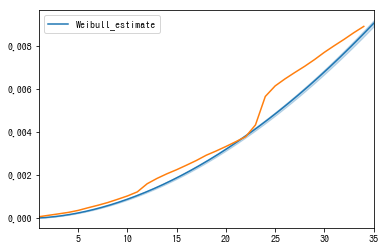

In [116]:
# フィット結果をプロット。累積ハザードプロットが表示される。
wf.print_summary()
wf.plot()
plt.plot(tmp.set_index("month_passed").sort_index()["cum_hazard"])

In [117]:
# カプラン・マイヤー推定を行う場合
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf = kmf.fit(ll_data_t + 1, ll_data_e)

In [118]:
tmp.tail()

,causal_part,month_passed,n_event,cutoff,total,sample_decrease,n_at_risk,survive_ratio,survival_function,term_length,hazard_rate,cum_hazard
756,55311-72J,30.0,474.0,33358.0,2344188.0,30286.0,1398355.0,0.999661,0.992307,1.0,0.000339,0.007721
757,55311-72J,31.0,418.0,28891.0,2344188.0,33832.0,1364523.0,0.999694,0.992003,1.0,0.000306,0.008028
758,55311-72J,32.0,395.0,22188.0,2344188.0,29309.0,1335214.0,0.999704,0.991709,1.0,0.000296,0.008323
759,55311-72J,33.0,411.0,19814.0,2344188.0,22583.0,1312631.0,0.999687,0.991399,1.0,0.000313,0.008637
760,55311-72J,34.0,374.0,1292032.0,2344188.0,20225.0,1292406.0,0.999711,0.991112,1.0,0.000289,0.008926


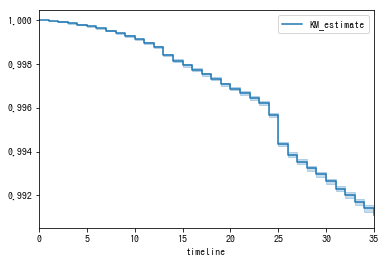

In [119]:
kmf.plot()

## 宿題

### 第12回(2019/8/28)宿題

- スズキ様グループのパーツについて、本notebookを参考に、ノンパラメトリックモデルで生存関数をモデリングし、2014年1月~12月について、予想故障数を計算してみましょう。

In [55]:
selected_part_S = ["46860-76G", "95200-58J", "37990-72J", "09262-350",
                   "17400-588"]

### 第13回(2019/9/4)宿題

- スズキ様グループのパーツについて、本notebookを参考に、パラメトリックモデル(ワイブル分布モデル)で生存関数をモデリングし、2014年1月~12月について、予想故障数を計算してみましょう。